# This notebook demostrates the augmentation of stellar grid models with Gaussian Process Regression (GPR) models.

# workflow: 

S1: Grid computation/selection: Given a star or a star sample with known observations, we could derive the ranges of inputs parameters. Assuming we are working on the Lund's star sample. We use the scalling relation to derive the mass range of the sample, which is from 0.9 - 1.1 solar mass. We could also know their evolving stages (main-sequence dwarf or early subgiants) by inspecting their locations on the HR diagram. Their metallicities are in a range of [Fe/H] = -0.3 -- 0.3 dex which are from the spectroscopy. Their helium fraction and mixing-length parameter are not unknow. We then use a typical ranges for these two parameters. 

S2: Select training data: Training data should cover the whole parameter sapce and we also need to highly-weighted the areas presenting sharp changes (if there are any).

S3: kernel selection and training data validation: we need a kernel which has proper flexibility to fit the feature of evolutionary tracks. A proper kernel should be able to well reproduece all training data. There could be multiple kernels. 

S4: test data validation: All good kernels will be validated with test data, which contents model data on the grid of training data (but not used for training) as well as model data which are off-grid. If the validation results are not good, go back to S2. There could be a couple iterations from S2 to S4.

S5: When the best model is found, use the validation results to estimate systematical uncertainty (could be another GP model.)



In [1]:
import GPy
import pickle
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
import pandas as pd
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import corner



# The lines below are specific to the notebook format
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

In [2]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None,valipath = None, savepath = None):
        self._datapath = datapath
        self._valipath = valipath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')

        if not os.path.exists(valipath):
            raise Warning(f'valipath:' + valipath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Validation path is set as' + self._valipath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, path = None,
                           condition = None, number = None,
                           columns = None,
                           ranges = None,
                           normalization = None):
        if path == None:
            raise Warning(f'$path$ must be given')

        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        #if (validation_frac == None):
        #    warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
        #    validation_frac = 0.2
    
        all_files = glob.glob(path + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        #print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = self.get_data_of_a_track(filename = filename, 
                                           columns = columns,
                                           ranges = ranges,
                                           normalization =normalization)
            df1.append(df0)
        
        df = []    
        df = pd.concat(df1, ignore_index=True)
        
        #random_state = 1

        #if (len(df['type'])*(1 - validation_frac) >= 10000):
        #    train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        #else:
        #    train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        #df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None, normalization = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
        
        #m = re.search('yinit(.+?)MLT', filename)
        #if m:
        #    found = m.group(1)
        
        #one_track['initial_Yinit'] = float(found)                
        #get rid of the pre-MS
        #one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        #one_track['type'] = 'data'
        one_track['hrgradient'] = ((np.gradient(one_track['effective_T']/5777.0))**2.0 
                                 + (np.gradient(one_track['log_g']/4.44))**2.0
                                  )**0.5
        
        one_track['fagegradient'] = np.gradient(one_track['frac_age'])
      
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
                one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
            else:
                one_track = None
                break
            if (normalization != None):
                if (normalization[i] > -999):
                    one_track[columns[i]] = one_track[columns[i]]/normalization[i]
        return one_track
    
    ##################### Plot section########################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    def plot_3d_data(self, x = None, y = None, z = None, c = None):
        fig = plt.figure()
        ax = Axes3D(fig)
        cp = ax.scatter(x, y, z, c = c, s=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        colorbar = plt.colorbar(cp)
        colorbar.set_label('c')
        return ax, colorbar 
    
    
   
      #####################Data generating#################
    def generate_2d_surface(self, xv = None, xvstep = None, xf1 = None, xf2 = None, number = None, factor = None):
    
        new_xv = []
        new_xf1 = []
        new_xf2 = []
    
        if factor == None: factor = 10
        
        number = min([factor*len(xv), number])
    
        for i in range(int(factor)):
            aa = xv + xvstep*(np.random.random(len(xv))-0.5)
            new_xv = np.concatenate((new_xv, aa))
            new_xf1 = np.concatenate((new_xf1, xf1))
            new_xf2 = np.concatenate((new_xf2, xf2))
            if (len(new_xv) >= number): break
    
        idxs = np.random.choice(arange(len(new_xv)), number)                           
    
    ######################GP models##################
    
    def kernel_bank(self, kname,input_dim):
        if kname == 'RBF': 
            k = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
        elif kname == 'EXP': 
            k = GPy.kern.Exponential(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
        elif kname == 'MLP': 
            k = GPy.kern.MLP(input_dim=input_dim, ARD = True)
        elif kname == 'MLP+RBF':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
            k = k1+k2
        elif kname == 'MLP+MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'MLP*MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=True)
            k = k1*k2
        elif kname == 'MLP+EXP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.Exponential(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'MLP+RQ':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.RatQuad(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'RQ':
            k = GPy.kern.RatQuad(input_dim = input_dim, ARD=True)
        elif kname == 'Mat32':
            k = GPy.kern.Matern32(input_dim = input_dim, ARD=True)
        else: 
            k = None
        return k

    
    def gp_a_dataframe(self, df = None, xcolumns = None, ycolumns = None, kname = None):
        
        start_time = time.time()
        nx = len(xcolumns)
        ny = len(ycolumns)
        #if (ny != 1):
        #    raise Warning(f'y must be 1 dimession!')

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        gpm = GPy.models.GPRegression(xx,yy,kernel)
        gpm.optimize()
        print("--- %s seconds ---" % (time.time() - start_time))
        return gpm
    
    ###################################################
    def load_a_gpm(self, df = None, npy = None, xcolumns = None, ycolumns = None, kname = None):
        
        nx = len(xcolumns)
        ny = len(ycolumns)

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        m_load = GPy.models.GPRegression(xx,yy,kernel,initialize=False)
        m_load.update_model(False) # do not call the underlying expensive algebra on load
        m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
        m_load[:] = np.load(npy) # Load the parameters
        m_load.update_model(True) # Call the algebra only once
        print(m_load)
        return m_load

    
    ######################inspecting model######################
    def inspect_gpm_on_1d(self, gpm = None, df = None, xcolumns = None, ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        gpy = gpm.predict(xx)
        
        for name in xcolumns:
            fig, ax = plt.subplots(1, figsize=(6,5))
            ax.scatter(df[name], df[ycolumns],s = 10, c = 'k')
            ax.scatter(df[name], gpy[0].reshape(ndf,), s = 5, c = 'r')
            ax.set_xlabel(name)
            ax.set_ylabel(ycolumns)
        return
    
        #########################
        #####################
    
    ####
    def inspect_gpm_on_2d(self, gpm = None, df = None, xcolumns = None, ycolumns = None, xplots = None,
                          randomshift = None, shiftfactor = None, title = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
            
        if shiftfactor == None: shiftfactor = 0.01
        if randomshift == True: xx = xx + shiftfactor*xx
        
        gpy = gpm.predict(xx)
        
        nc = len(xplots)
        if nc < 2: raise Warning(f'xplots must be >=2 dimession!')
        
        for i in range(nc):
            name1 = xplots[i]
            for i2 in range(nc-i-1):
                name2 = xplots[i+i2+1]
                print(name1, name2)
                fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
                cp = ax1.scatter(df[name1], df[name2], c = (df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]],s = 2)
                #ax.scatter(df[name1], df[name2], c = gpy[0].reshape(ndf,), s = 15)
                ax1.set_xlabel(name1)
                ax1.set_ylabel(name2)
                colorbar = plt.colorbar(cp)
                colorbar.set_label(ycolumns[0] + '(Grid - GP)/Grid')
                ax2.hist((df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]], bins = 50)
                if title != None: ax1.set_title(title)
        return

    ######################sampling##############################
    def guassian_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        y = 1.0/(sigma*(2.0*np.pi)**0.5)*np.exp(-0.5*((x - mu)/sigma)**2.0)
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def uniform_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        data_array = (np.random.choice(n,n)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def linear_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def age_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x**2
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def mle(self, model, obs, obs_e):
        lk = 1.0/ (2.0*3.14159*obs_e**2.0)**(0.5) * np.exp( 0.0 - (model - obs)**2.0/2.0/obs_e**2.0 )
        return lk
    
    def sample_results(self, df = None, lkname = None, f = None):
        df[lkname] = df[lkname]/np.sum(df[lkname])
        newdf = df.copy()
        for index, row in df.iterrows():
            copies = int(f*row[lkname])
            for i in range(copies):
                newdf = newdf.append(row,ignore_index=True)
        newdf.drop(index = df.index,inplace=True)
        return newdf
    
    def sample_cmd(self, gpm = None, df = None, prediction = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ccolumns = None, mcolumns = None):
        nx = len(xcolumns)
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.scatter(df[ccolumns], df[mcolumns],c = df[prediction], s = 5)
            
        ndf = len(df)
        
        df2 = df.copy()
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        
        ax2.scatter(df2[ccolumns],df2[mcolumns],c = gpp[0].reshape(ndf,), s = 5)
        ax1.set_xlabel(ccolumns)
        ax1.set_ylabel(mcolumns)
        ax1.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax2.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax1.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax2.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax1.set_title('Model Grid')
        ax2.set_xlabel(ccolumns)
        ax2.set_title('GP predictions')
        return 
    
    def sample_with_df(self, n = None, df = None, gpm = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        
        df2 = df.copy()
        if (len(df2) < n):
            for i in range(100):
                df2 = pd.concat([df2, df])
                if len(df2)>n: break
        
        df2.index = range(len(df2))
        
        ndf = len(df2)
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        df2[ycolumns] = gpp[0]
        df2['gp_var'] = gpp[1].reshape(ndf,)
        
        #for yname in ycolumns:
        #    index = ycolumns.index(yname)
        #    gpp = gpm[index].predict(xx)
        #    df2[yname] = gpp[0].reshape(ndf,)
        #    df2[yname + '_var'] = gpp[1].reshape(ndf,)
        return df2



In [3]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_alex/'
savedr = '/Users/litz/Documents/GitHub/GPGrid/paper_used/2D_fun_to_obs/'
validr = '/Users/litz/Documents/GitHub/data/validation_data/simple_grid_vali_2d/'
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr, valipath = validr)

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_alex/
Validation path is set as/Users/litz/Documents/GitHub/data/validation_data/simple_grid_vali_2d/
Save path is set as/Users/litz/Documents/GitHub/GPGrid/paper_used/2D_fun_to_obs/


# section 3.2 3D-inputs GPR models: p = f(mass, frac_age, initial feh)

In [4]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [0.00,99.0],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [3.8000,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]

df = gmk.get_data_of_a_grid(path = gmk._datapath,
                               condition = 'm*Y0.28FeH0.0MLT2.1ov0.0dif1.csv', number = None,
                               columns = columns,
                               ranges = ranges, 
                               normalization = normalization)
df['initial_zx'] = 10**df['initial_feh']*0.0181
df['star_zx'] = 10**df['star_feh']*0.0181
df['frac_age'] = 10**df['frac_age']

df.sample()

df.to_csv(savedr + 'df.csv')
df

41 tracks are found


 /opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning:$number$ is missing, all file will be used


evol_stage  initial_mass  initial_Yinit  initial_feh  initial_MLT  \
0               1          0.95           0.28          0.0          2.1   
1               1          0.95           0.28          0.0          2.1   
2               1          0.95           0.28          0.0          2.1   
3               1          0.95           0.28          0.0          2.1   
4               1          0.95           0.28          0.0          2.1   
...           ...           ...            ...          ...          ...   
21383           2          0.93           0.28          0.0          2.1   
21384           2          0.93           0.28          0.0          2.1   
21385           2          0.93           0.28          0.0          2.1   
21386           2          0.93           0.28          0.0          2.1   
21387           2          0.93           0.28          0.0          2.1   

        star_age   frac_age    ms_age  effective_T     log_g    radius  \
0       0.126235   1.025744  8.823142  5709.534381  4.557235  0.849550   
1       0.144792   1.029584  8.823142  5710.284701  4.556440  0.850328   
2       0.167059   1.034210  8.823142  5711.011597  4.555595  0.851156   
3       0.193781   1.039790  8.823142  5711.778660  4.554684  0.852049   
4       0.225846   1.046525  8.823142  5712.636685  4.553688  0.853027   
...          ...        ...       ...          ...       ...       ...   
21383  12.346441   9.966206  9.661853  5085.195058  3.816086  1.970020   
21384  12.351233   9.975104  9.661853  5080.519365  3.812293  1.978633   
21385  12.355854   9.983691  9.661853  5076.093980  3.808595  1.987068   
21386  12.360314   9.991986  9.661853  5071.872325  3.804957  1.995400   
21387  12.364619  10.000000  9.661853  5067.912440  3.801444  2.003479   

       star_feh  delta_nu_fit       nu_max  hrgradient  fagegradient  \
0     -0.001467    168.224898  4104.481101    0.000223      0.001928   
1     -0.001733    167.996699  4096.705390    0.000225      0.002313   
2     -0.002052    167.754675  4088.478180    0.000236      0.002776   
3     -0.002433    167.494558  4079.638364    0.000257      0.003331   
4     -0.002889    167.210509  4069.984651    0.000286      0.003998   
...         ...           ...          ...         ...           ...   
21383 -0.023045     47.490041   789.324175    0.001203      0.000505   
21384 -0.022741     47.169728   782.820352    0.001154      0.000487   
21385 -0.022438     46.859703   776.521018    0.001115      0.000470   
21386 -0.022234     46.555093   770.363950    0.001072      0.000454   
21387 -0.021927     46.264592   764.456173    0.001034      0.000439   

       initial_zx   star_zx  
0          0.0181  0.018039  
1          0.0181  0.018028  
2          0.0181  0.018015  
3          0.0181  0.017999  
4          0.0181  0.017980  
...           ...       ...  
21383      0.0181  0.017165  
21384      0.0181  0.017177  
21385      0.0181  0.017189  
21386      0.0181  0.017197  
21387      0.0181  0.017209  

[21388 rows x 18 columns]

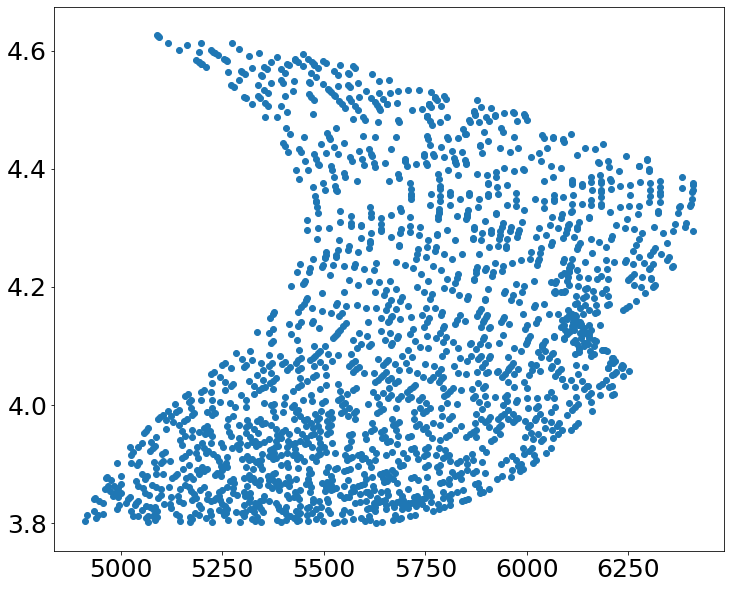

In [6]:
gdf = None
gdf = df.sample(n = 2000, weights = 'hrgradient',random_state = 1000)
gdf.index = range(len(gdf))

#dfv_ongrid = df.sample(n = 5000, weights = 'hrgradient',random_state = 9999)
#dfv_ongrid.index = range(len(dfv_ongrid))
#dfv_ongrid.to_csv(savedr + 'dfv_ongrid.csv')

plt.scatter(gdf['effective_T'], gdf['log_g'])

In [6]:
g1d = df[(df.initial_mass == 1.1)]
g1d = g1d.sample(frac = 1.0, weights = 'hrgradient', random_state = 1000)
g1d.index = range(len(g1d))
g1d['frac_age'] = np.log10(g1d['frac_age'])
gpm1d = gmk.gp_a_dataframe(df = g1d, xcolumns = ['frac_age'], ycolumns = ['effective_T'], kname = 'MLP')
pred = gmk.sample_with_df(n = 1, df = g1d, gpm = gpm1d, 
                          xcolumns = ['frac_age'], xshift = [0.00], 
                          randomshift = False, ycolumns =['effective_T'])

g1dx = df[(df.initial_mass == 1.1)]
g1dx = g1dx.sample(frac = 1.0, weights = 'hrgradient', random_state = 1000)
g1dx.index = range(len(g1dx))
gpm1dx = gmk.gp_a_dataframe(df = g1dx, xcolumns = ['frac_age'], ycolumns = ['effective_T'], kname = 'MLP')
predx = gmk.sample_with_df(n = 1, df = g1dx, gpm = gpm1dx, 
                          xcolumns = ['frac_age'], xshift = [0.00], 
                          randomshift = False, ycolumns =['effective_T'])

--- 4.238125801086426 seconds ---
--- 4.573323965072632 seconds ---


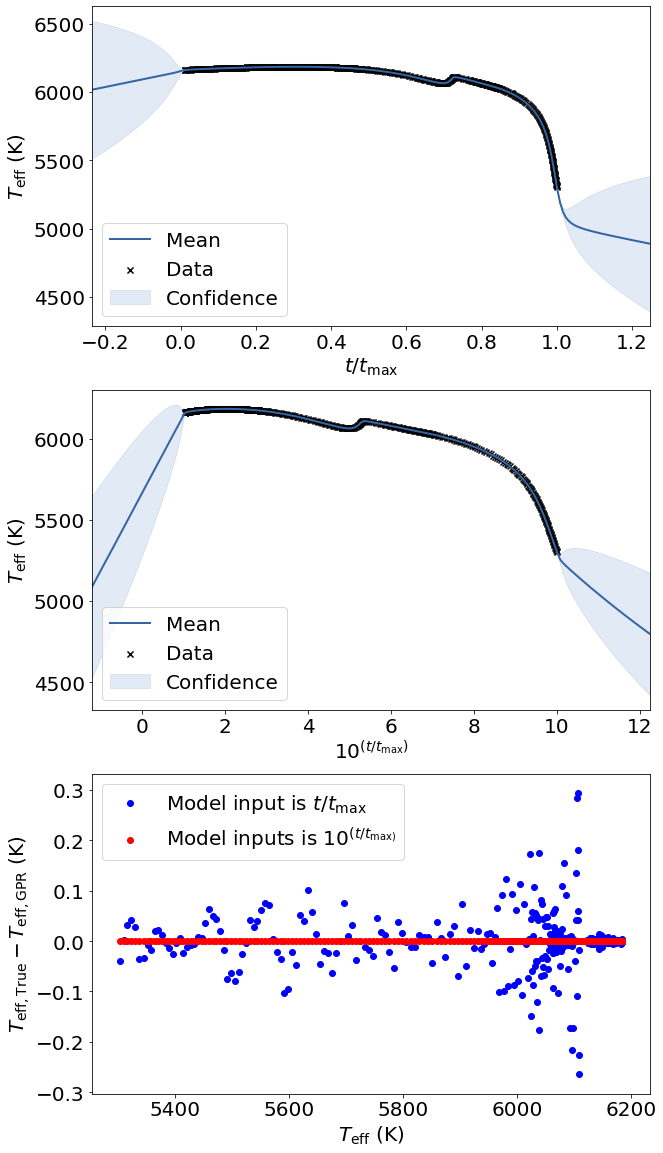

In [42]:
textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

offset = g1d['effective_T'] - pred['effective_T']
offsetx = g1dx['effective_T'] - predx['effective_T']
fig, ax = plt.subplots(3,1, figsize = (10,20))
gpm1d.plot(ax = ax[0])
ax[0].set_xlabel(r'$t/t_{\rm max}$')
ax[0].set_ylabel(r'$T_{\rm eff}$ (K)')
gpm1dx.plot(ax = ax[1])
ax[1].set_xlabel(r'$10^{(t/t_{\rm max})}$')
ax[1].set_ylabel(r'$T_{\rm eff}$ (K)')


ax[2].scatter(g1d['effective_T'],offset, c = 'b', label = r'Model input is $t/t_{\rm max}$')
ax[2].scatter(g1dx['effective_T'],offsetx, c = 'r', label = r'Model inputs is $10^{(t/t_{\rm max)}}$')
ax[2].set_xlabel(r'$T_{\rm eff}$ (K)')
ax[2].set_ylabel(r'$T_{\rm eff, True} - T_{\rm eff, GPR}$ (K)')
ax[2].legend()
fig.savefig(gmk._savepath + 'selection_of_t.pdf')

In [43]:
np.max(offsetx)

0.00017190240669151535

In [11]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [0.00,99.0],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [3.8000,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]
dfv = gmk.get_data_of_a_grid(path = gmk._valipath,
                                condition = '*.csv', number = None,
                                columns = columns,
                                ranges = ranges, 
                                normalization = normalization)
dfv['initial_zx'] = 10**dfv['initial_feh']*0.0181
dfv['star_zx'] = 10**dfv['star_feh']*0.0181
dfv['frac_age'] = 10**dfv['frac_age']


dfv = dfv.sample(n = 1000,weights = 'hrgradient', random_state = 1000)

#dfv = dfv[(dfv['frac_age']>=1.5) & (dfv['frac_age']<=9.9#)]
dfv.index = range(len(dfv))
dfv.to_csv(savedr + 'dfv_.csv')
dfv

 /opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning:$number$ is missing, all file will be used


15 tracks are found


evol_stage  initial_mass  initial_Yinit  initial_feh  initial_MLT  \
0             2      1.166024           0.28          0.0          2.1   
1             2      1.043901           0.28          0.0          2.1   
2             1      0.955599           0.28          0.0          2.1   
3             2      1.128018           0.28          0.0          2.1   
4             1      0.908224           0.28          0.0          2.1   
..          ...           ...            ...          ...          ...   
995           2      0.955599           0.28          0.0          2.1   
996           2      0.813665           0.28          0.0          2.1   
997           2      1.168693           0.28          0.0          2.1   
998           2      0.934013           0.28          0.0          2.1   
999           2      1.168693           0.28          0.0          2.1   

      star_age  frac_age     ms_age  effective_T     log_g    radius  \
0     5.144972  9.575540   4.136311  5722.926429  3.839363  2.148781   
1     7.903160  9.602251   5.862122  5488.150513  3.886437  1.924888   
2     7.371947  4.558464   8.624573  5842.279940  4.321049  1.118299   
3     4.469256  5.614105   4.593694  6090.485972  4.150202  1.479053   
4     2.704334  1.587283  10.653165  5624.002959  4.533541  0.853632   
..         ...       ...        ...          ...       ...       ...   
995  11.179182  9.978488   8.624573  5113.748643  3.812399  2.005407   
996  19.852628  9.865715  16.517045  4984.562140  3.874691  1.722564   
997   5.017361  9.245543   4.106419  5849.673939  3.869602  2.077842   
998  11.780393  9.286110   9.470665  5482.349190  3.993236  1.610434   
999   4.952579  8.983811   4.106419  5913.481677  3.892873  2.023054   

     star_feh  delta_nu_fit       nu_max  hrgradient  fagegradient  \
0   -0.038734     47.275189   785.014326    0.001253      0.000880   
1   -0.027336     52.522927   893.402758    0.001208      0.000672   
2   -0.103826    112.394500  2355.489575    0.000218      0.002273   
3   -0.149311     80.419734  1556.680953    0.000851      0.001741   
4   -0.031525    163.505787  3915.995655    0.000183      0.002783   
..        ...           ...          ...         ...           ...   
995 -0.021358     46.870712   780.464277    0.001502      0.000656   
996 -0.037418     54.451762   912.433481    0.000940      0.000344   
997 -0.054811     49.766995   832.452582    0.001386      0.001586   
998 -0.047445     64.956891  1143.077564    0.001355      0.001097   
999 -0.061723     51.756624   873.524767    0.002114      0.003082   

     initial_zx   star_zx  
0        0.0181  0.016556  
1        0.0181  0.016996  
2        0.0181  0.014251  
3        0.0181  0.012834  
4        0.0181  0.016833  
..          ...       ...  
995      0.0181  0.017231  
996      0.0181  0.016606  
997      0.0181  0.015954  
998      0.0181  0.016227  
999      0.0181  0.015702  

[1000 rows x 18 columns]

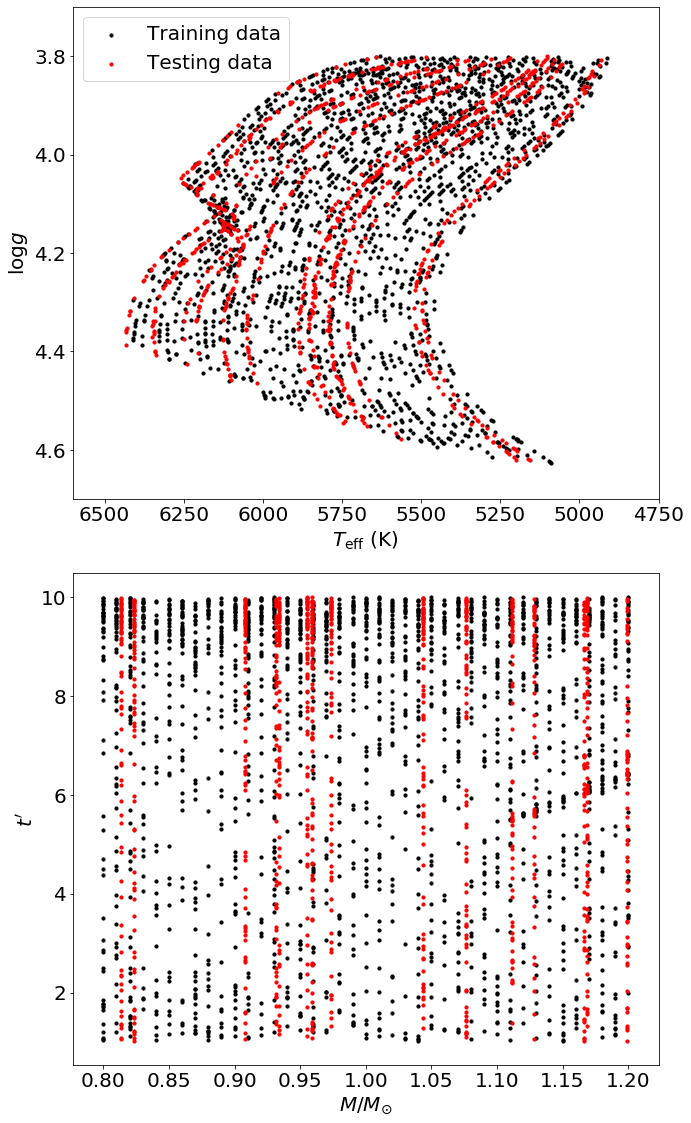

In [12]:
textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(2,1, figsize = (10,16))
cp = ax[0].scatter(gdf['effective_T'], gdf['log_g'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
ax[0].scatter(dfv['effective_T'], dfv['log_g'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
ax[0].set_xlabel(r'$T_{\rm eff}$ (K)')
ax[0].set_ylabel(r'$\log g$')
ax[0].set_xlim([6600,4750])
ax[0].set_ylim([4.7,3.7])
ax[0].legend(fontsize = 20)

cp = ax[1].scatter(gdf['initial_mass'], gdf['frac_age'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
ax[1].scatter(dfv['initial_mass'], dfv['frac_age'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
ax[1].set_xlabel(r'$M/M_{\odot}$')
ax[1].set_ylabel(r"$t'$")
fig.tight_layout()
fig.savefig(gmk._savepath + '2d_data_on_HR.pdf')
#ax1.set_title('MESA grid models')

In [13]:
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T'] #,'log_g','radius', 'star_age','star_zx', 'delta_nu_fit']

In [14]:
gpm0 = gmk.gp_a_dataframe(df = gdf, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP')
gpp0 = gmk.sample_with_df(n = 1, df = dfv, gpm = gpm0, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)

--- 48.04859805107117 seconds ---


In [11]:
np.save(gmk._savepath + 'gpm_mlp.npy', gpm0.param_array)
gdf.to_csv(savedr + 'gpm.csv')

0.8
--- 8.236667156219482 seconds ---
0.81
--- 3.69702410697937 seconds ---
0.82
--- 3.807447671890259 seconds ---
0.83
--- 2.7052600383758545 seconds ---
0.84
--- 3.1751487255096436 seconds ---
0.85
--- 3.662680149078369 seconds ---
0.86
--- 6.54724907875061 seconds ---
0.87
--- 7.738176107406616 seconds ---
0.88
--- 4.881340980529785 seconds ---
0.89
--- 8.250181198120117 seconds ---
0.9
--- 7.6005470752716064 seconds ---
0.91
--- 5.400301933288574 seconds ---
0.92
--- 3.7915351390838623 seconds ---
0.93
--- 9.537717819213867 seconds ---
0.94
--- 9.807968854904175 seconds ---
0.95
--- 7.558411121368408 seconds ---
0.96
--- 8.265496015548706 seconds ---
0.97
--- 12.271130800247192 seconds ---
0.98
--- 2.221791982650757 seconds ---
0.99
--- 7.286647081375122 seconds ---
1.0
--- 13.553362131118774 seconds ---
1.01


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 2.4278106689453125 seconds ---
1.02


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 7.517071962356567 seconds ---
1.03


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 2.2094311714172363 seconds ---
1.04


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 2.9534201622009277 seconds ---
1.05


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 2.4891550540924072 seconds ---
1.06


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 5.6080100536346436 seconds ---
1.07


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 4.169334888458252 seconds ---
1.08


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 5.609559774398804 seconds ---
1.09


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 1.3412449359893799 seconds ---
1.1


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 4.927856922149658 seconds ---
1.11


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 5.880087852478027 seconds ---
1.12


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 7.878493785858154 seconds ---
1.13


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 5.495276927947998 seconds ---
1.14


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 6.742149829864502 seconds ---
1.15


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 5.75377082824707 seconds ---
1.16


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 1.9866890907287598 seconds ---
1.17


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 4.166494131088257 seconds ---
1.18


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 1.8568382263183594 seconds ---
1.19


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 4.810341119766235 seconds ---
1.2


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- 1.6954379081726074 seconds ---


 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


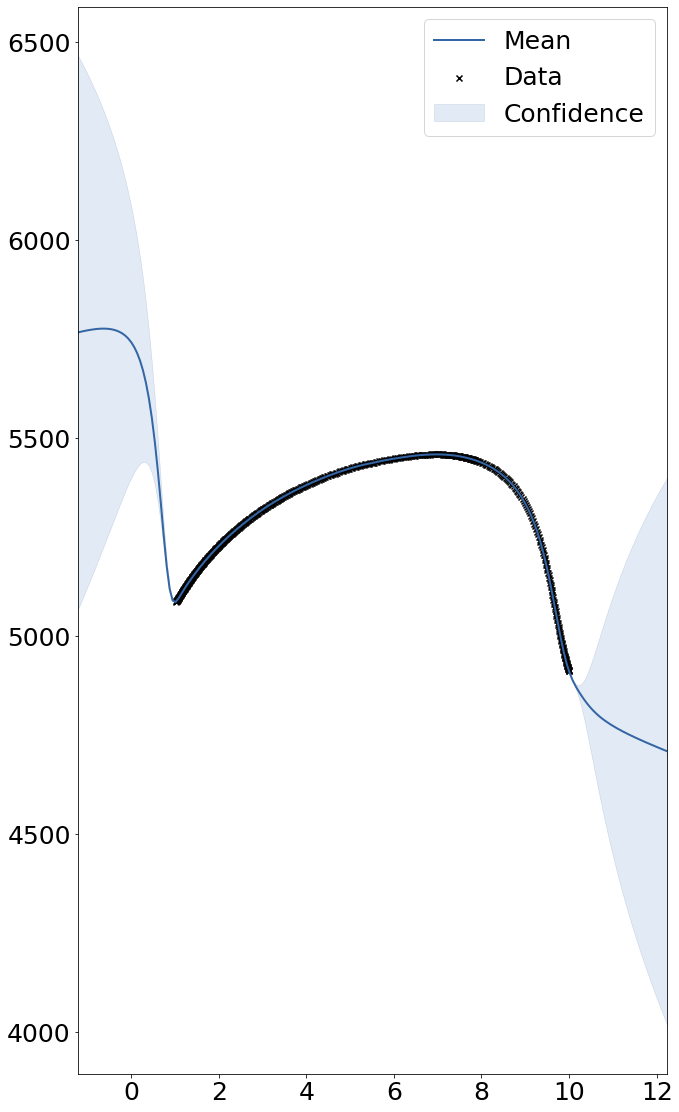

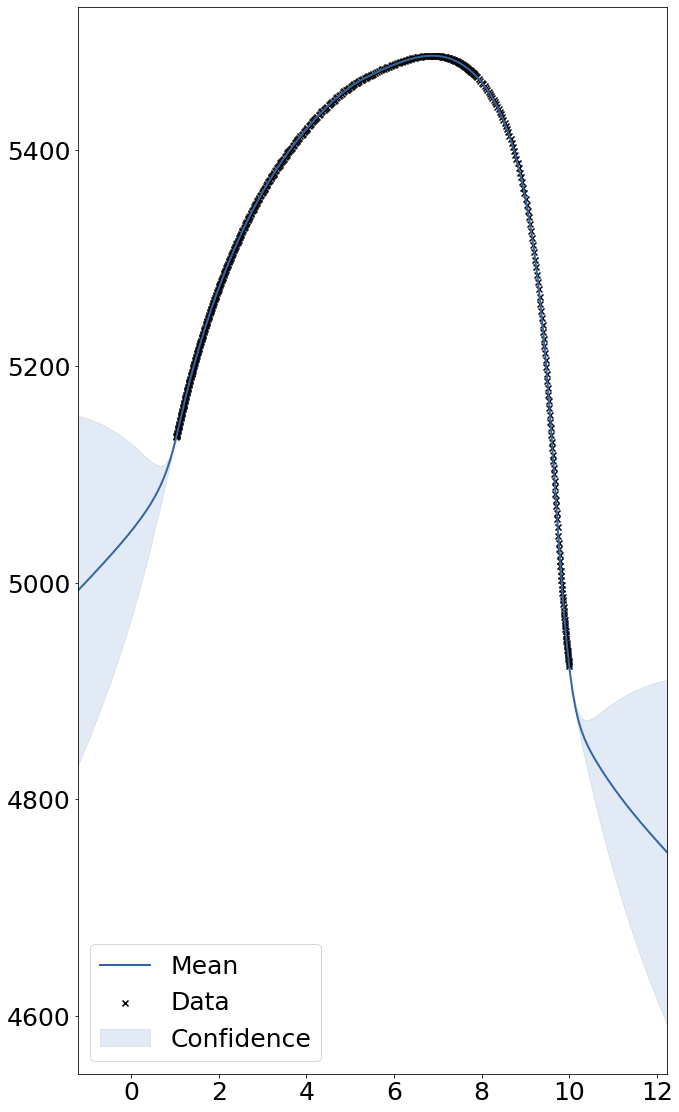

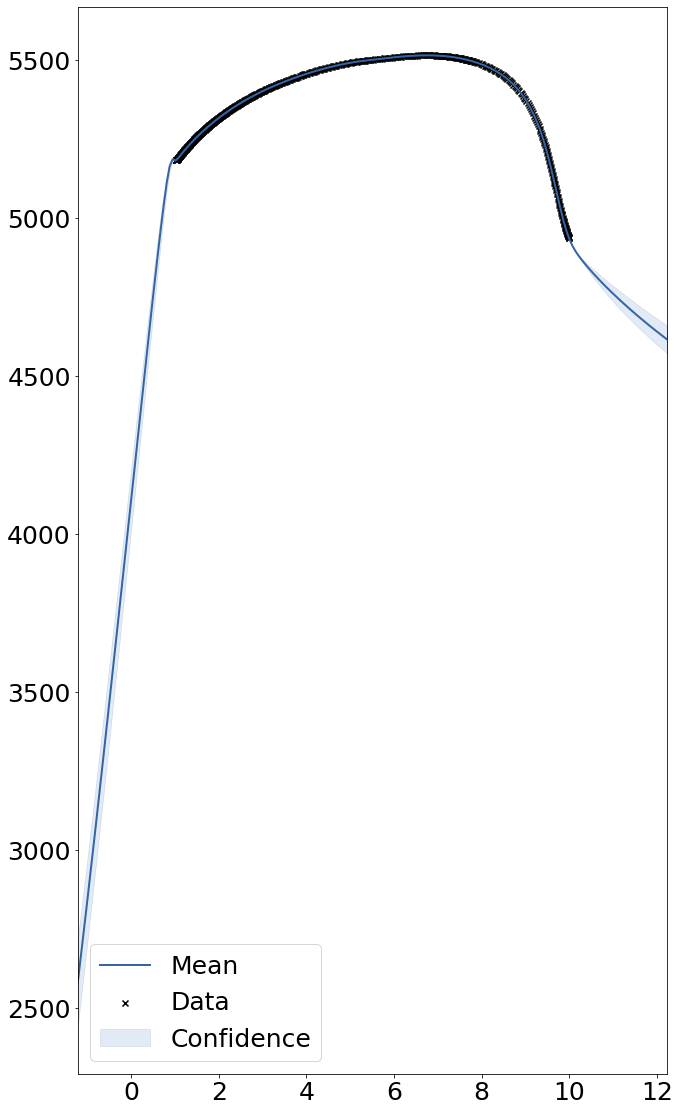

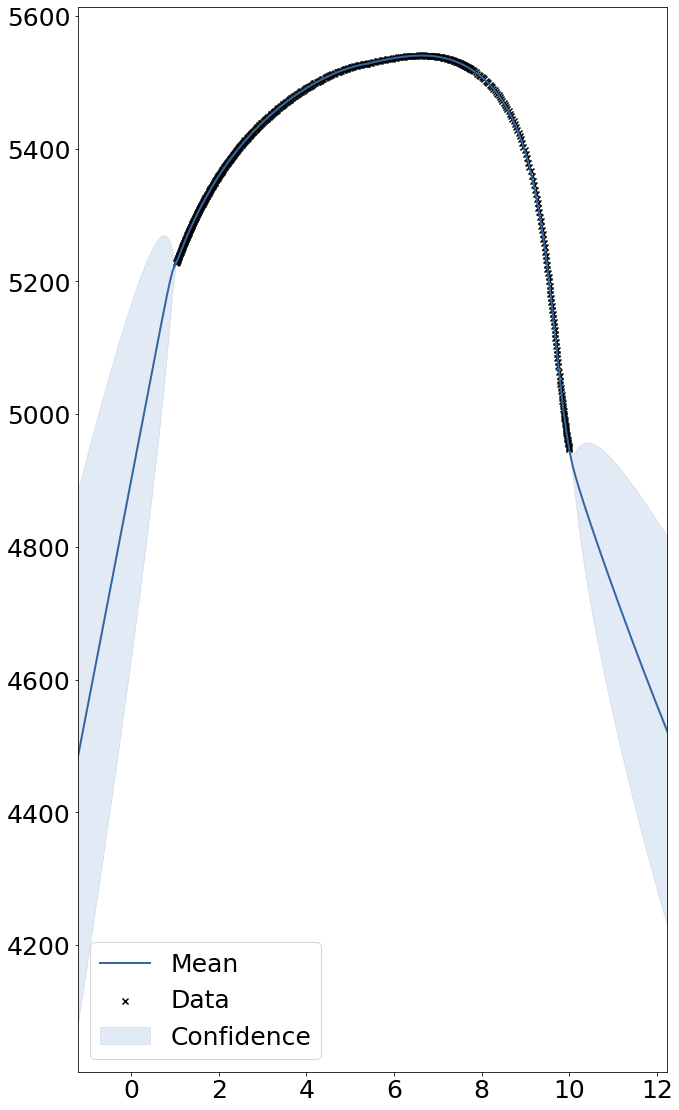

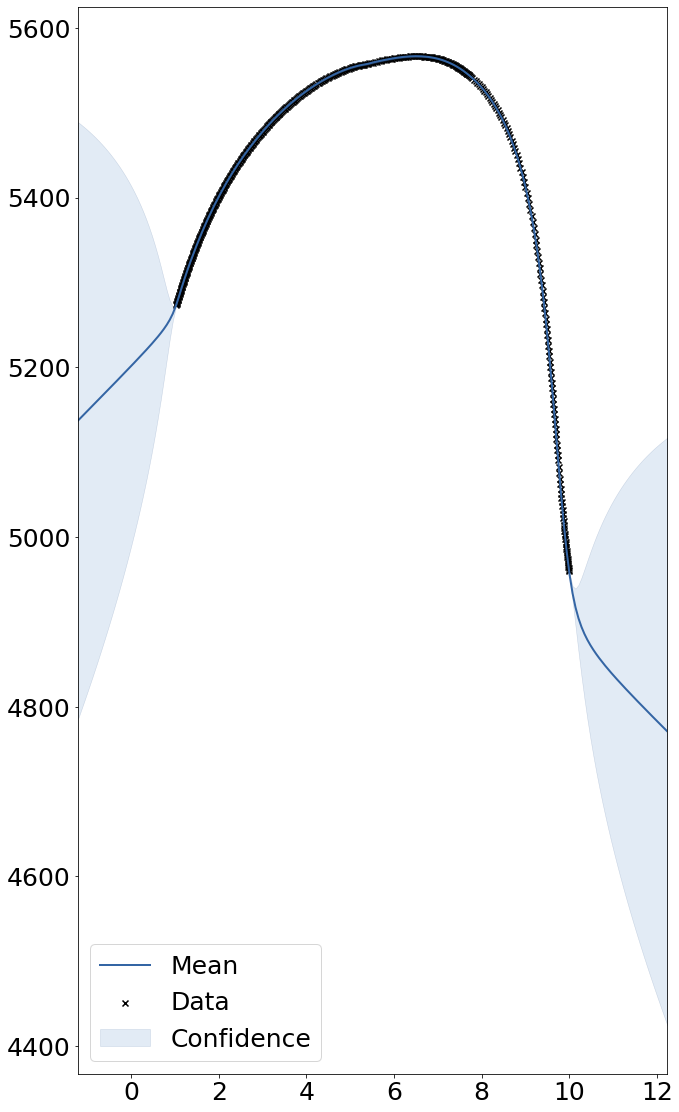

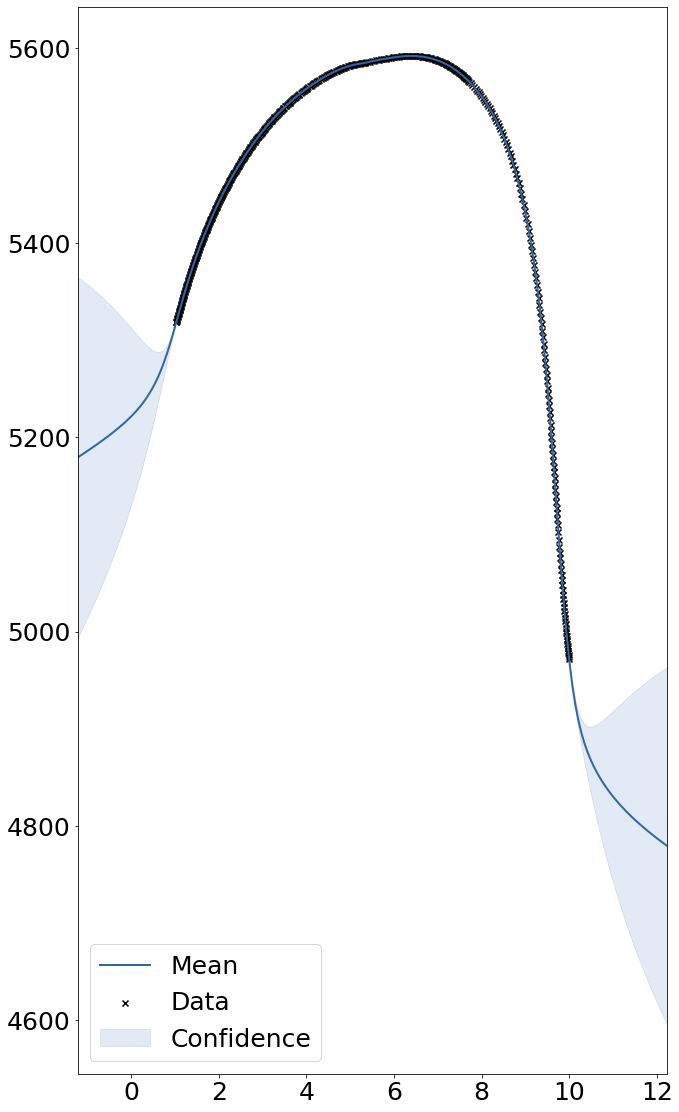

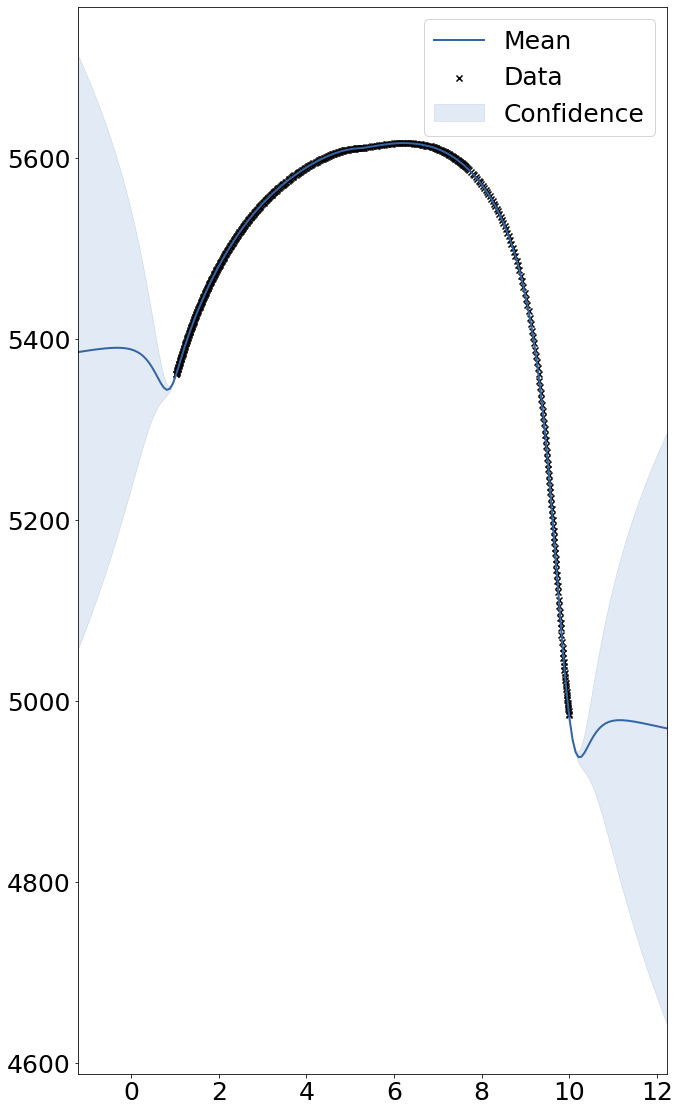

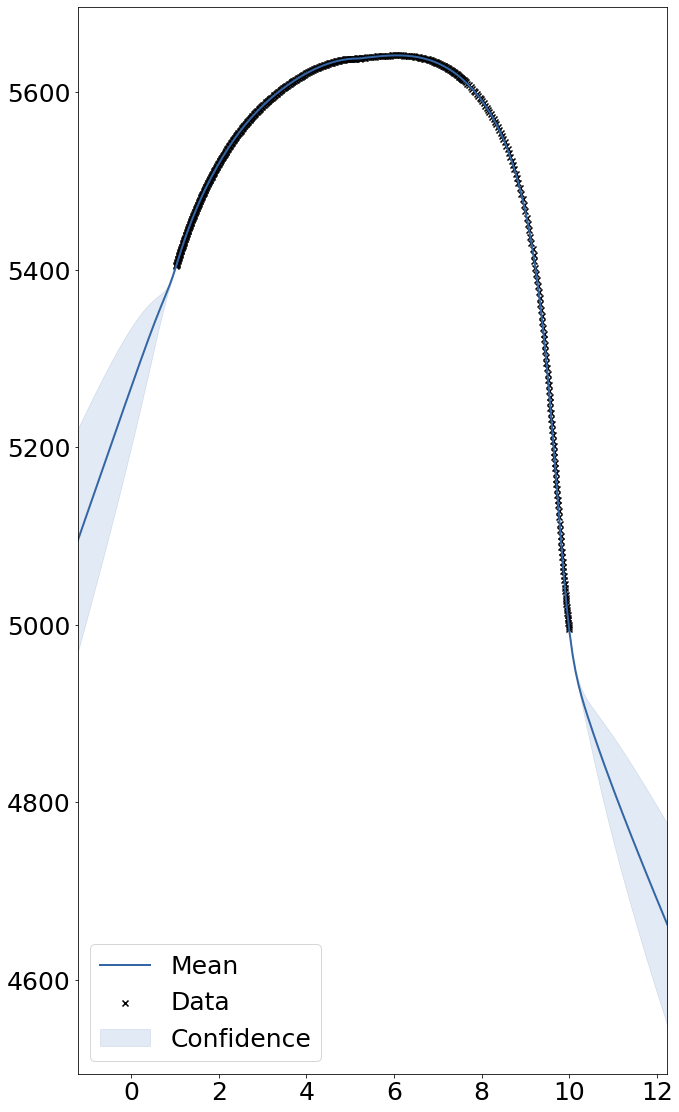

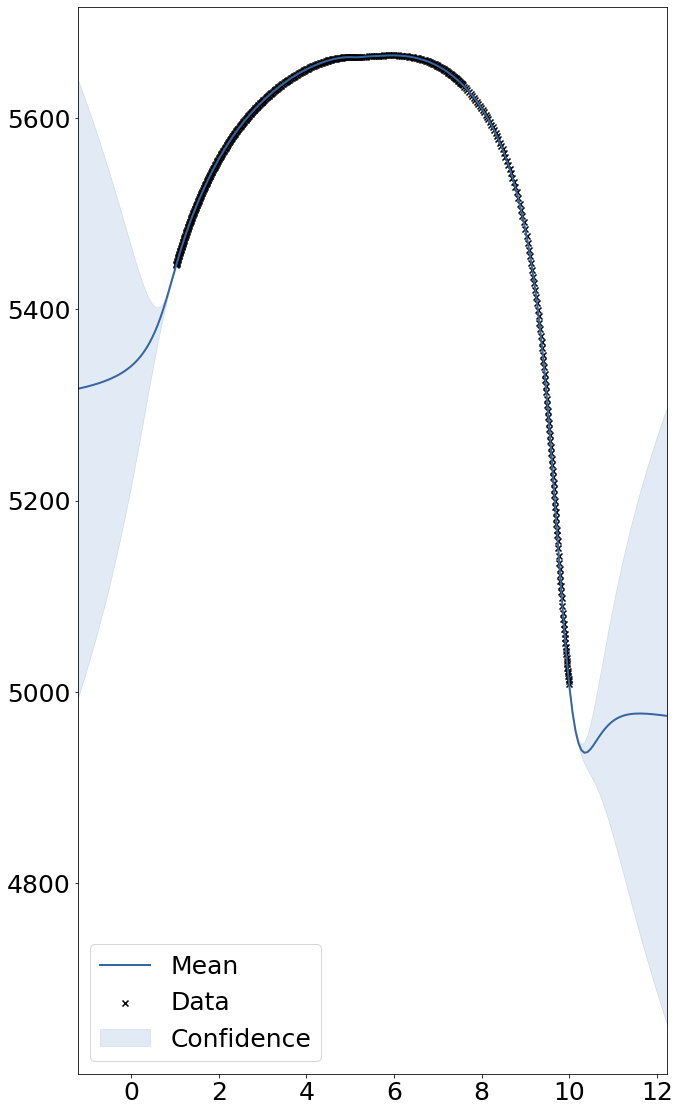

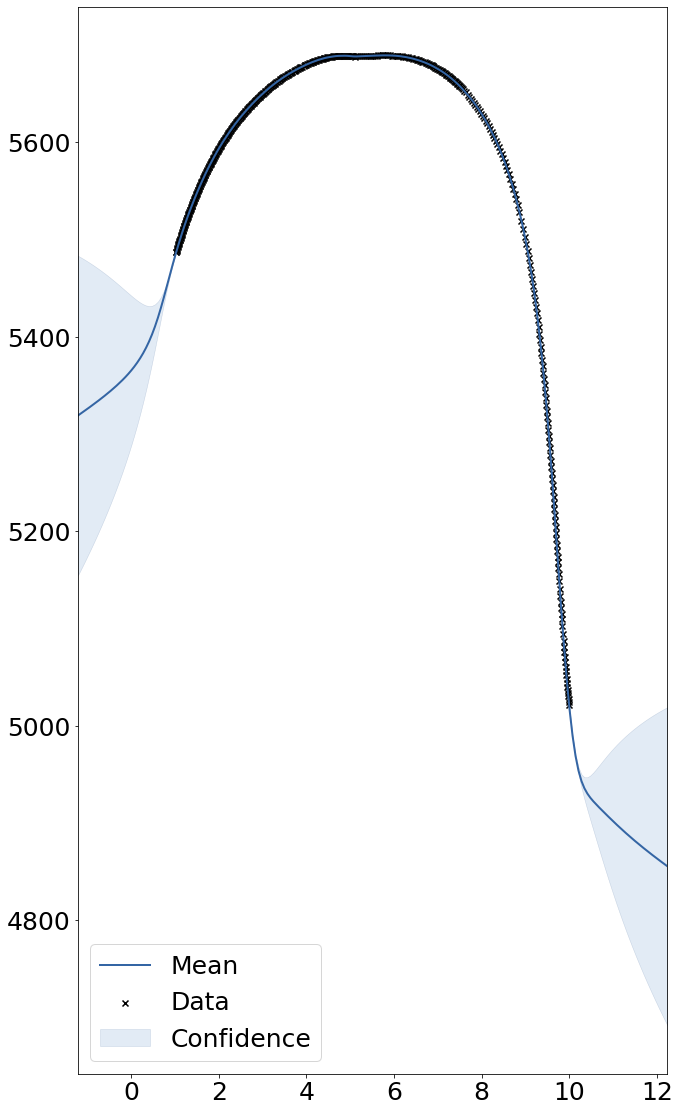

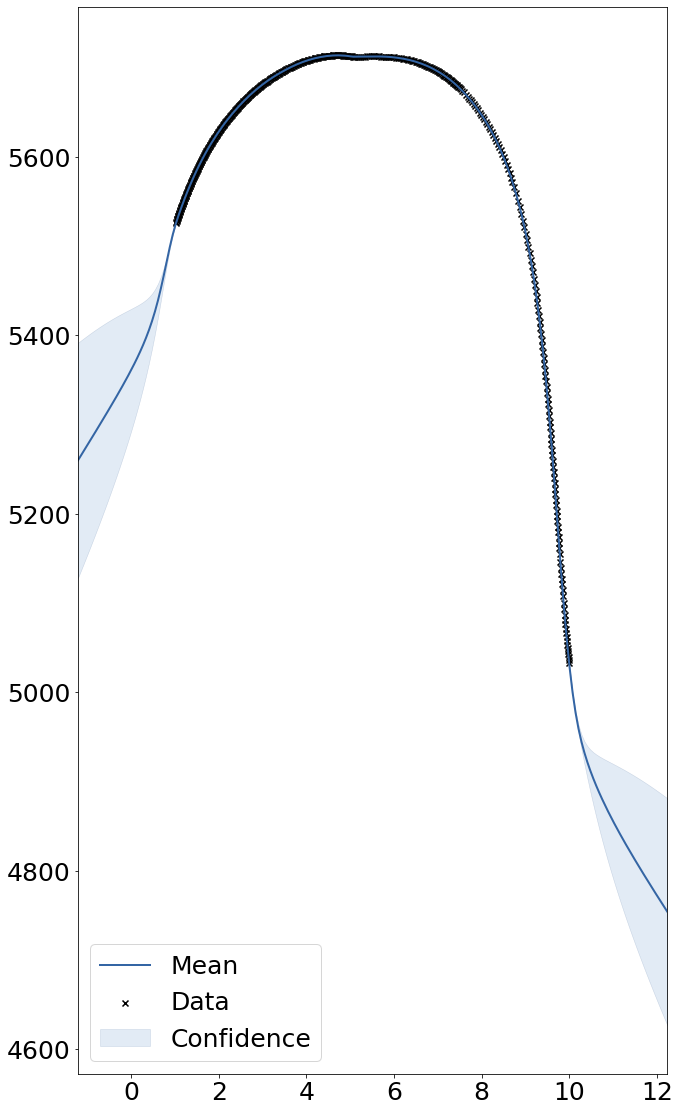

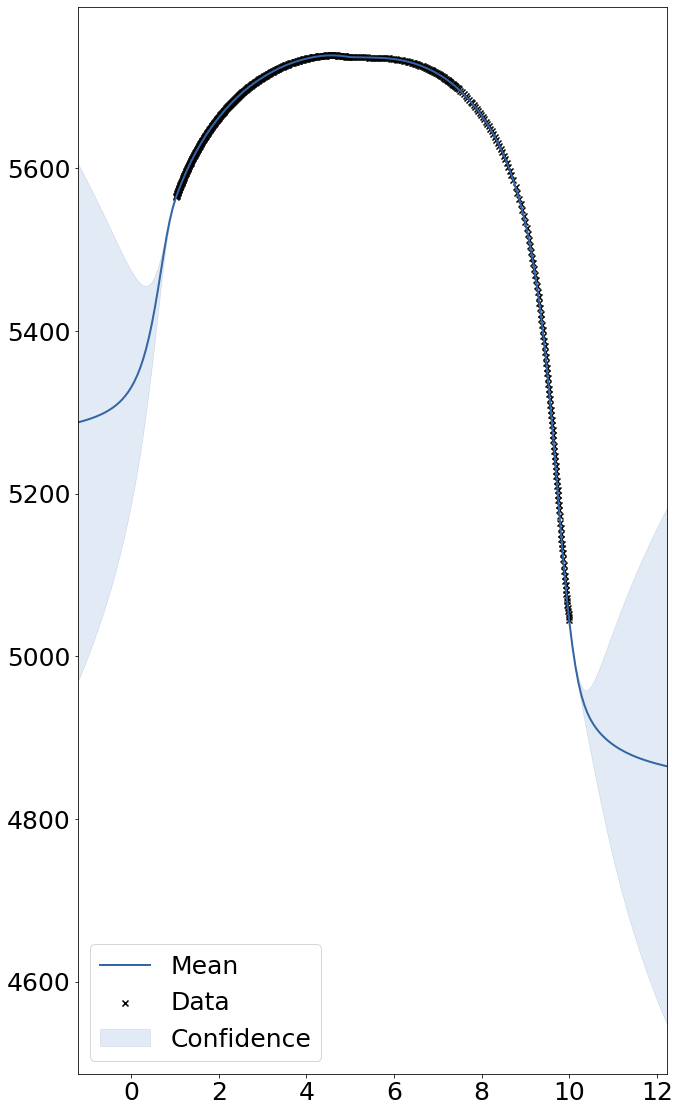

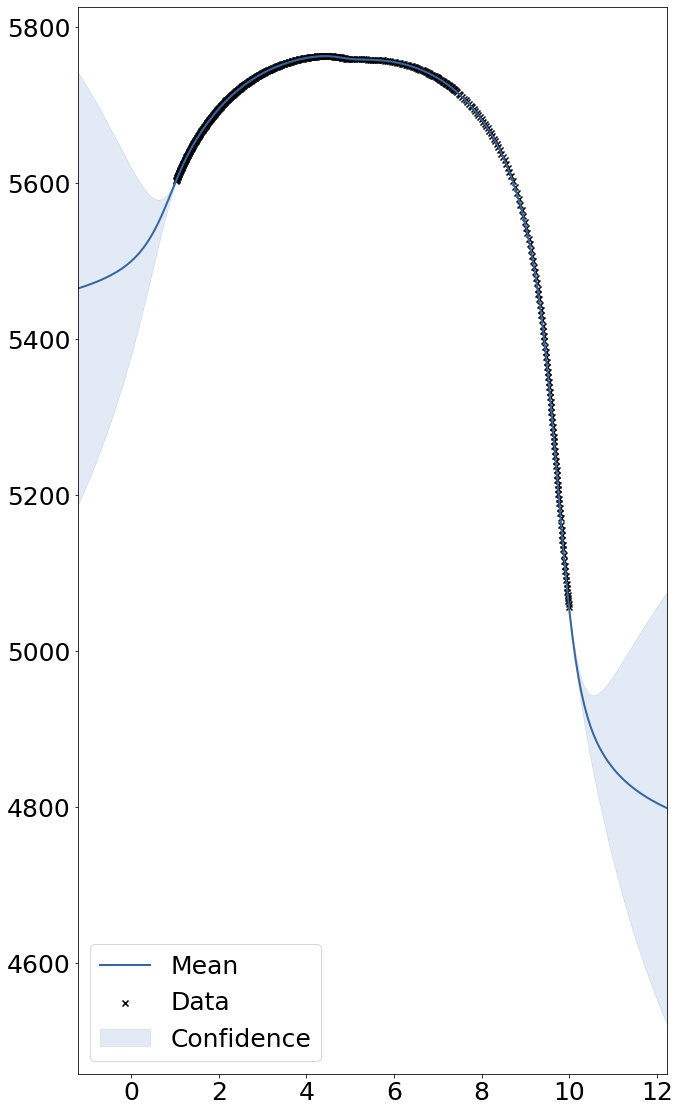

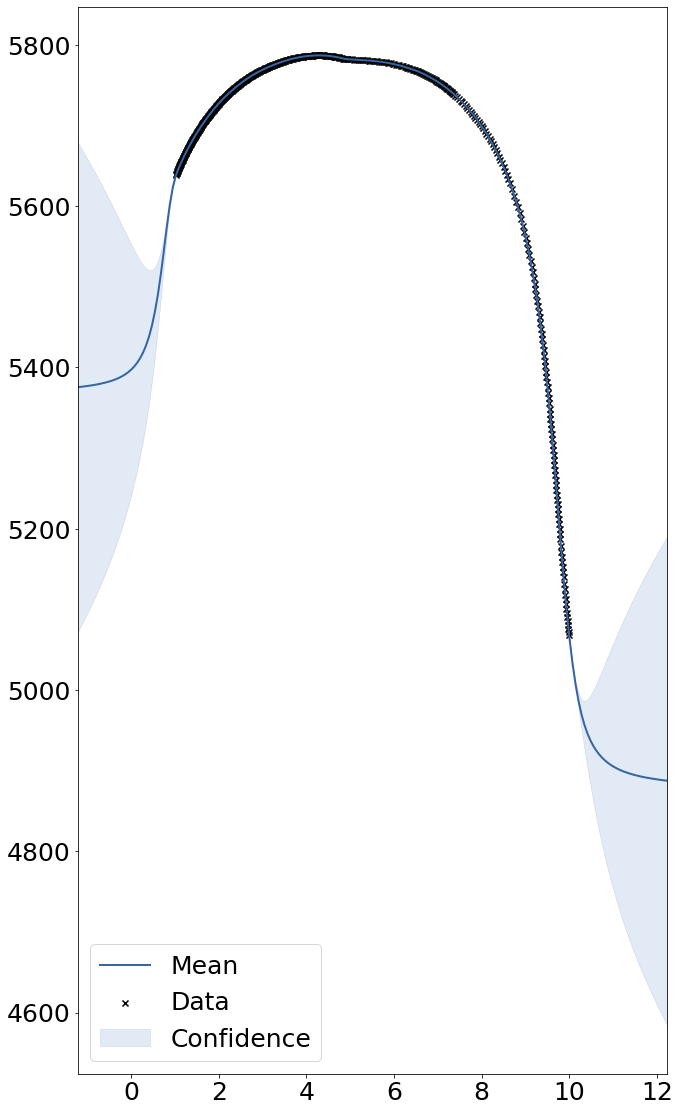

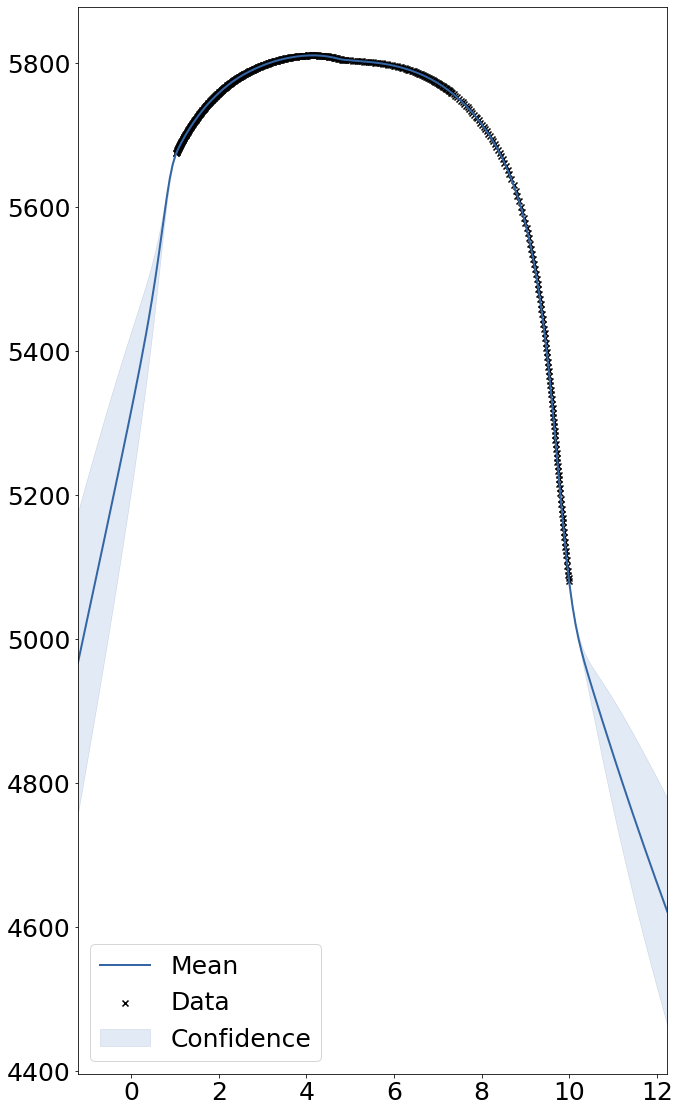

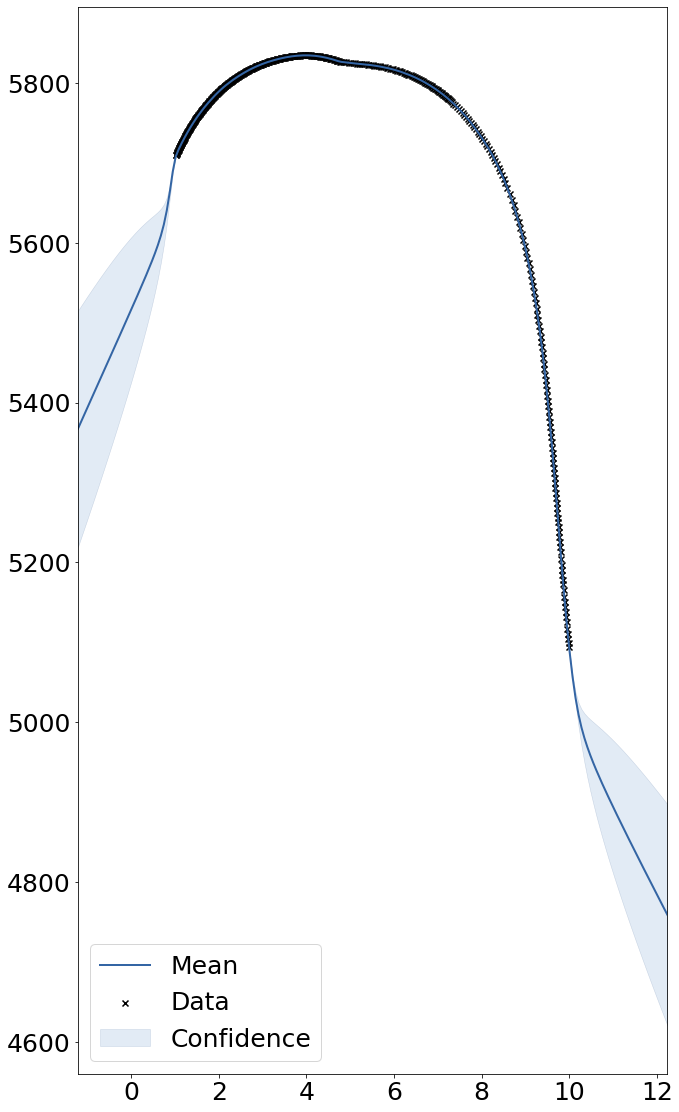

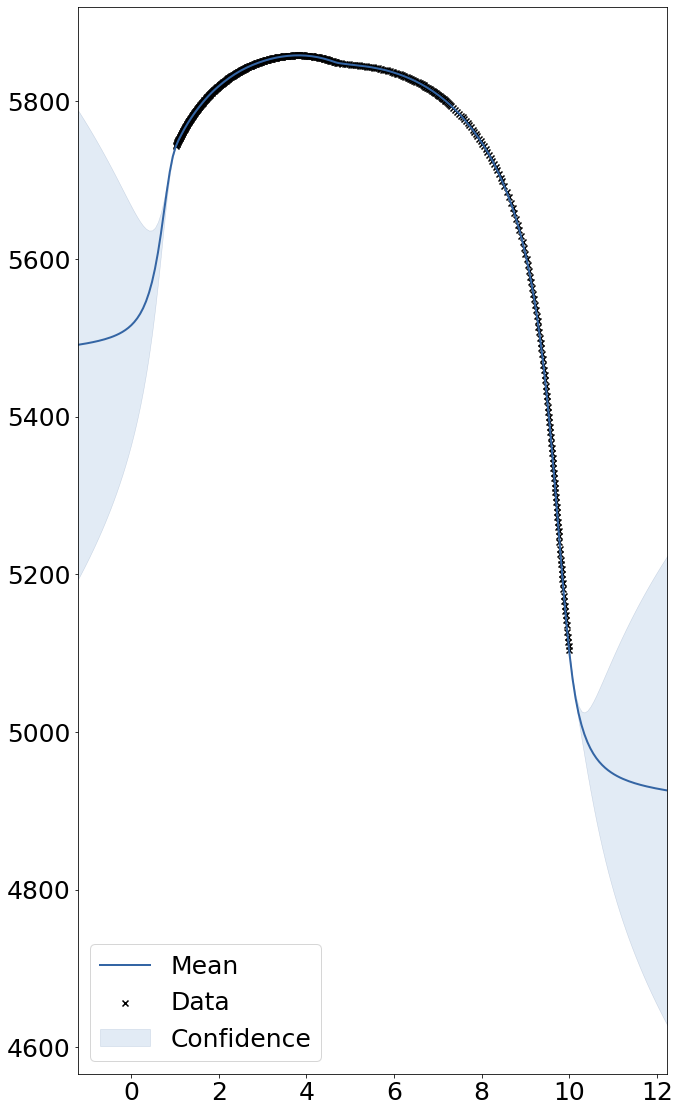

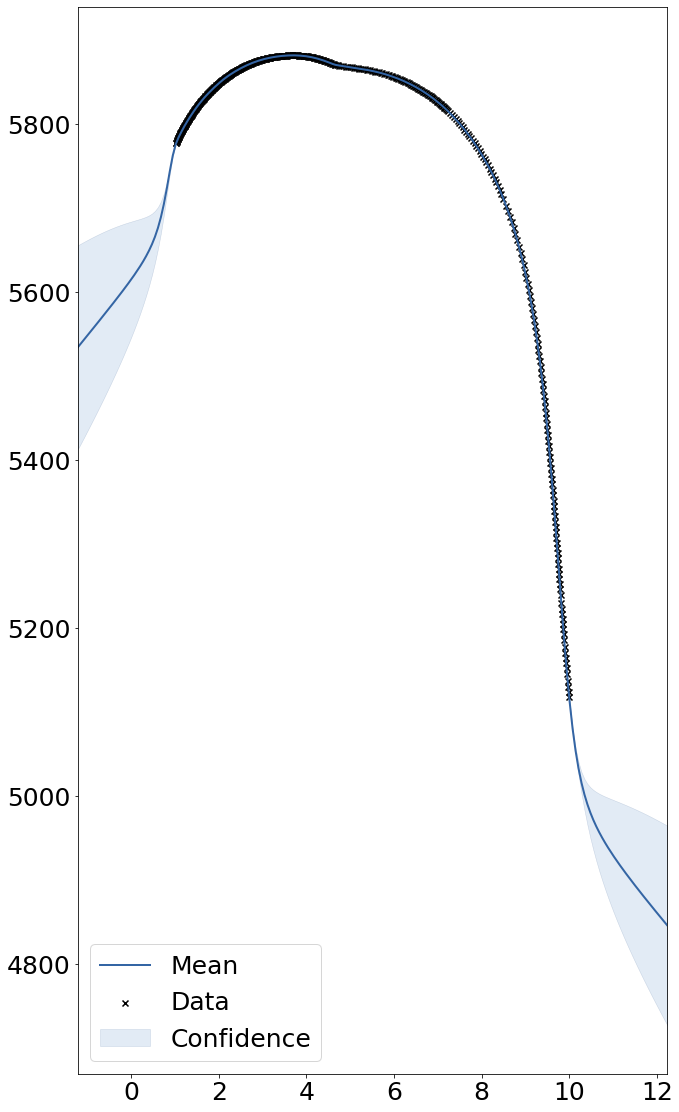

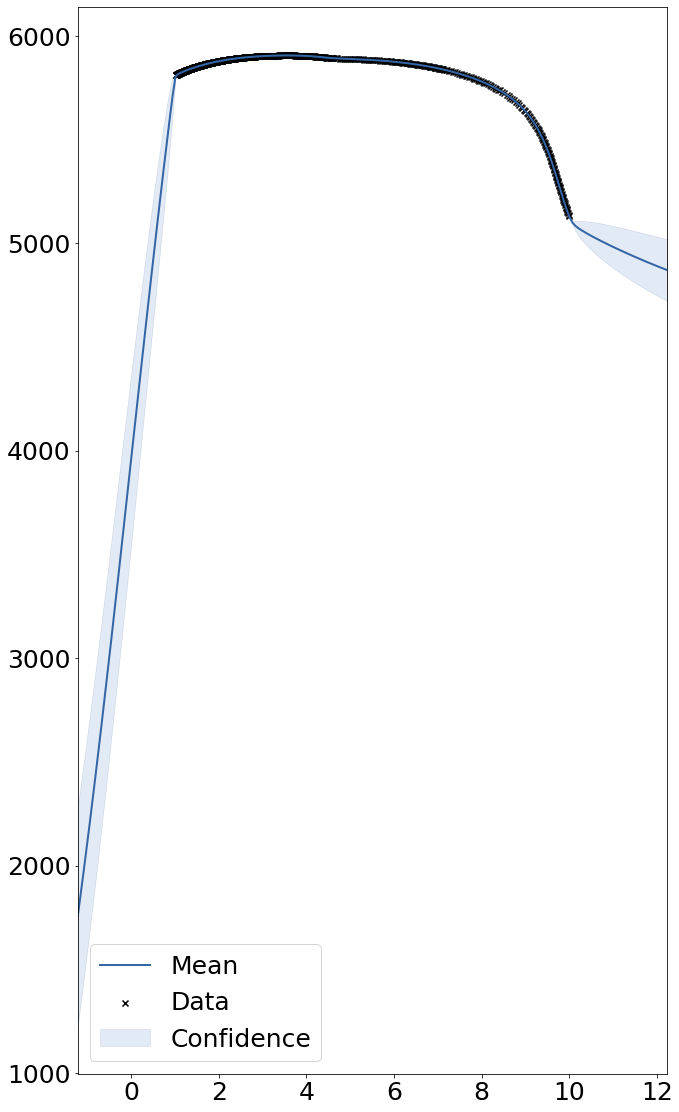

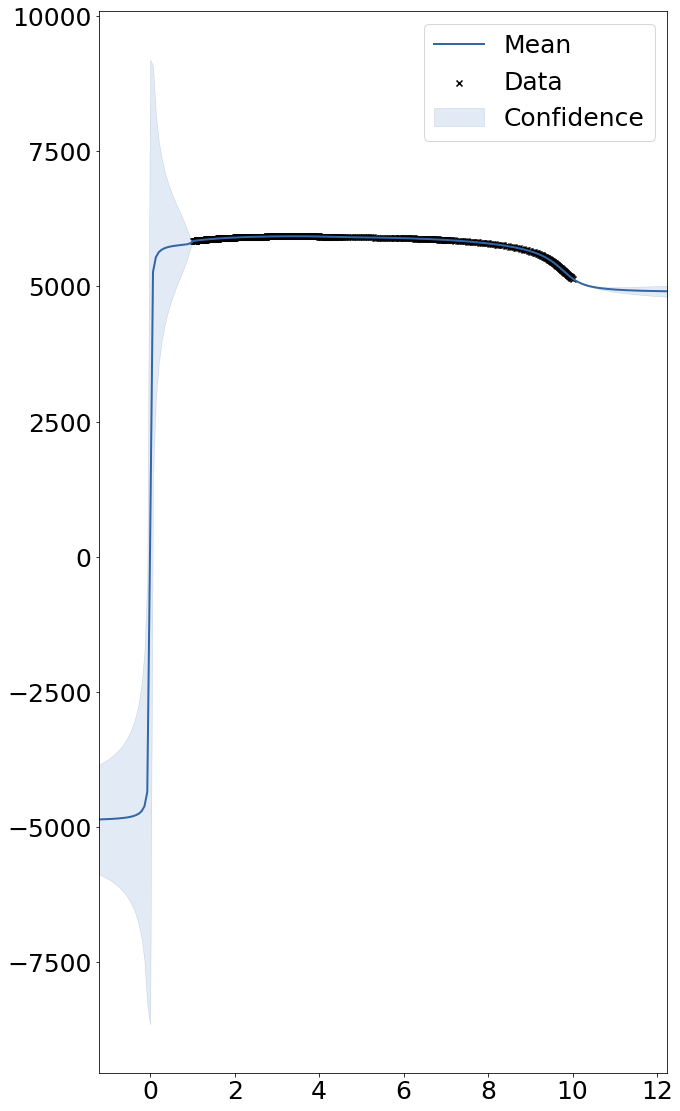

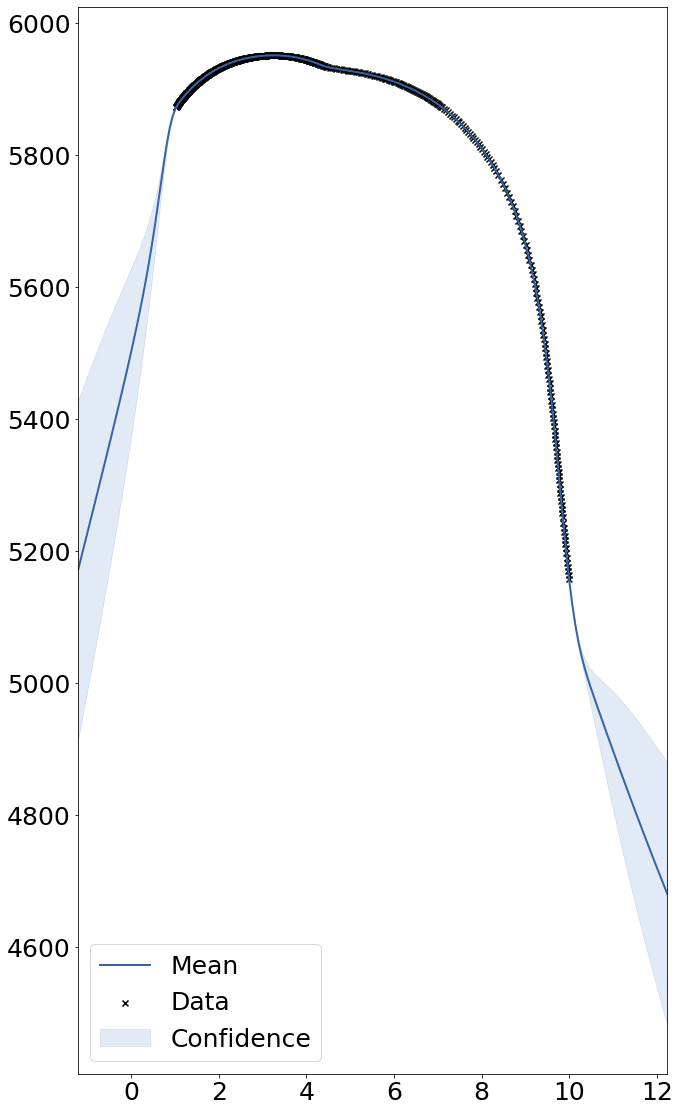

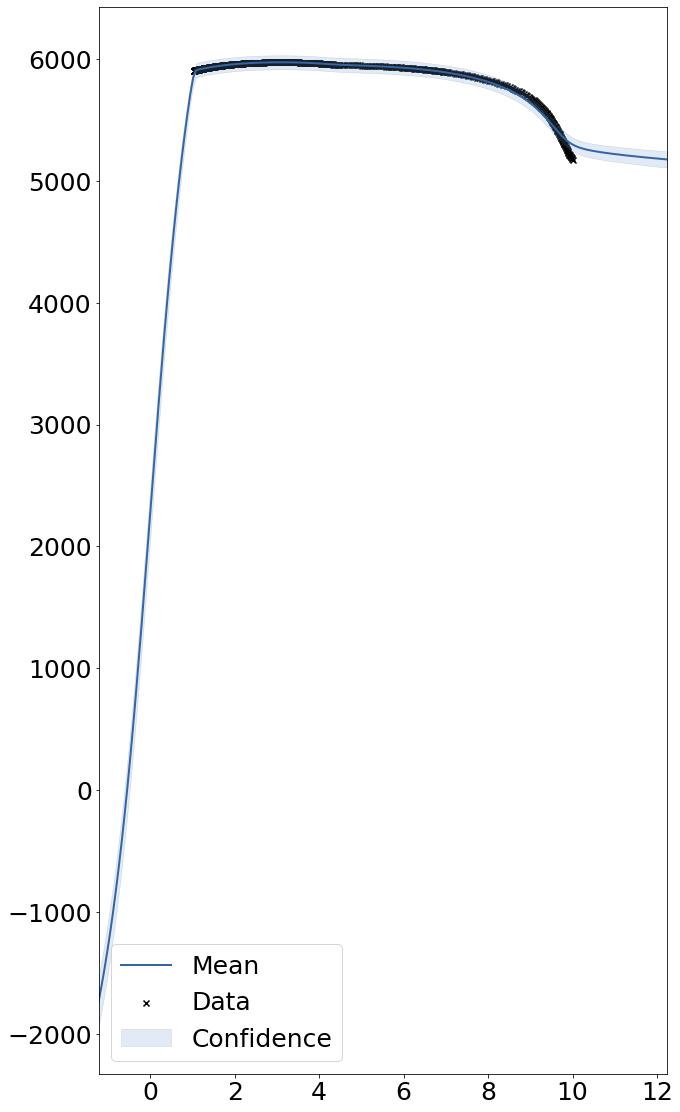

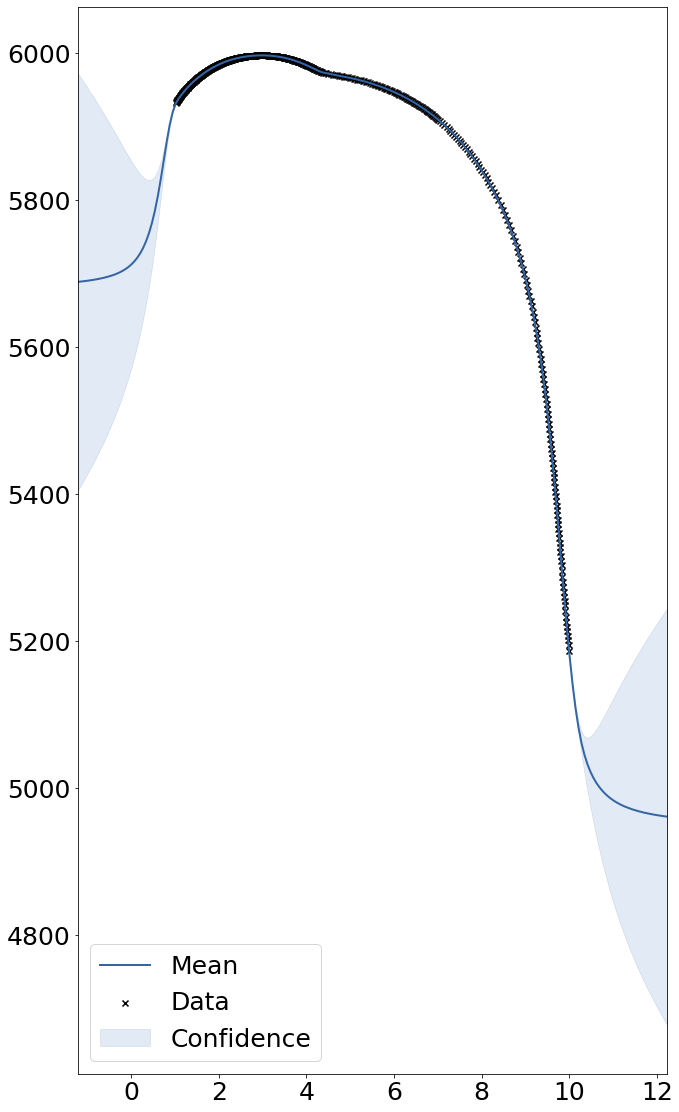

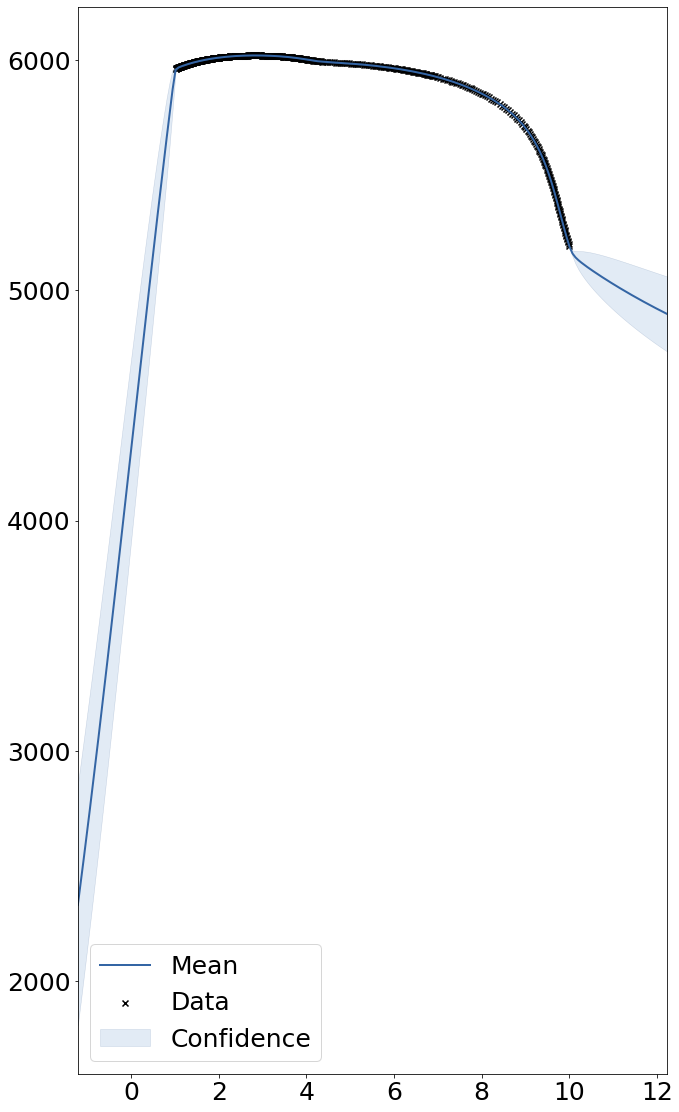

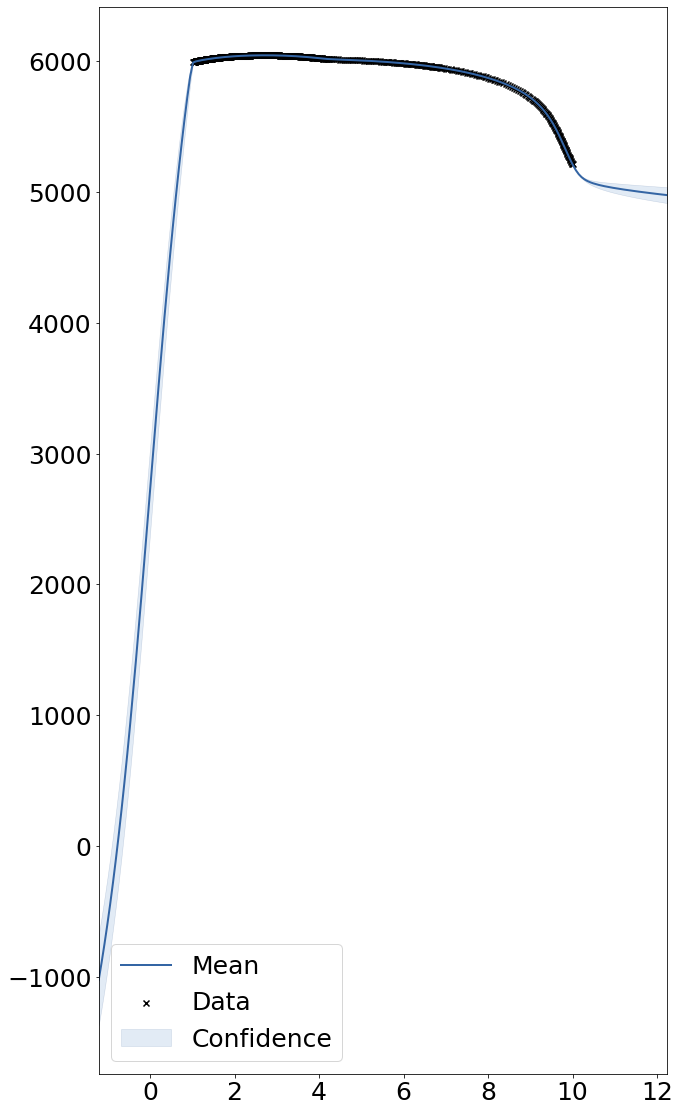

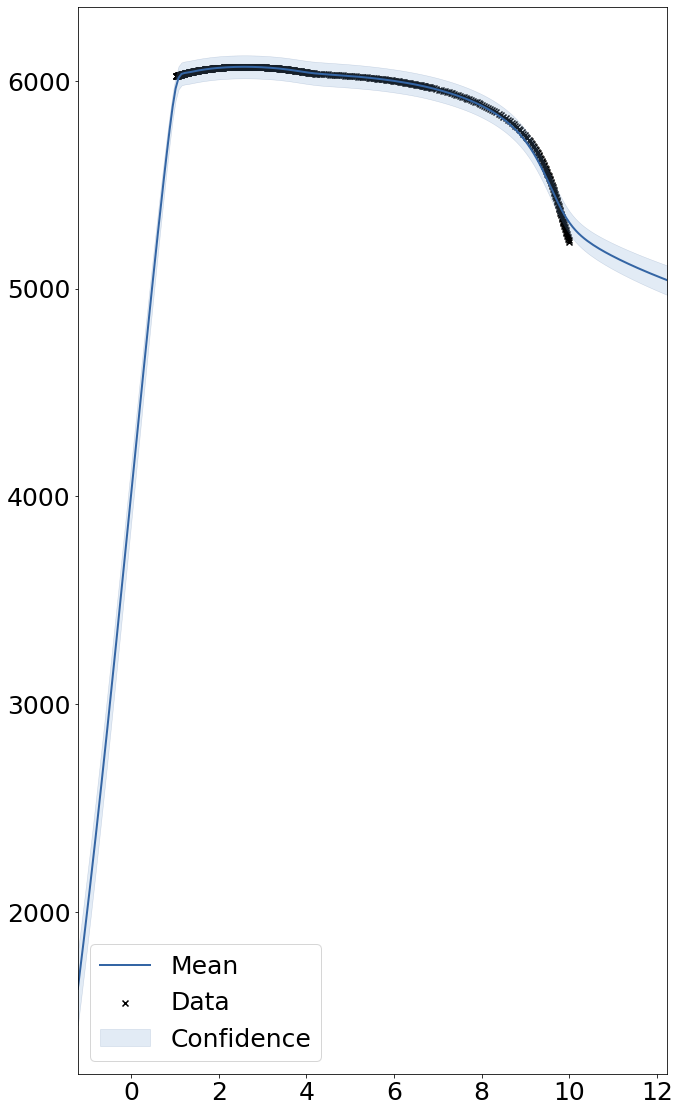

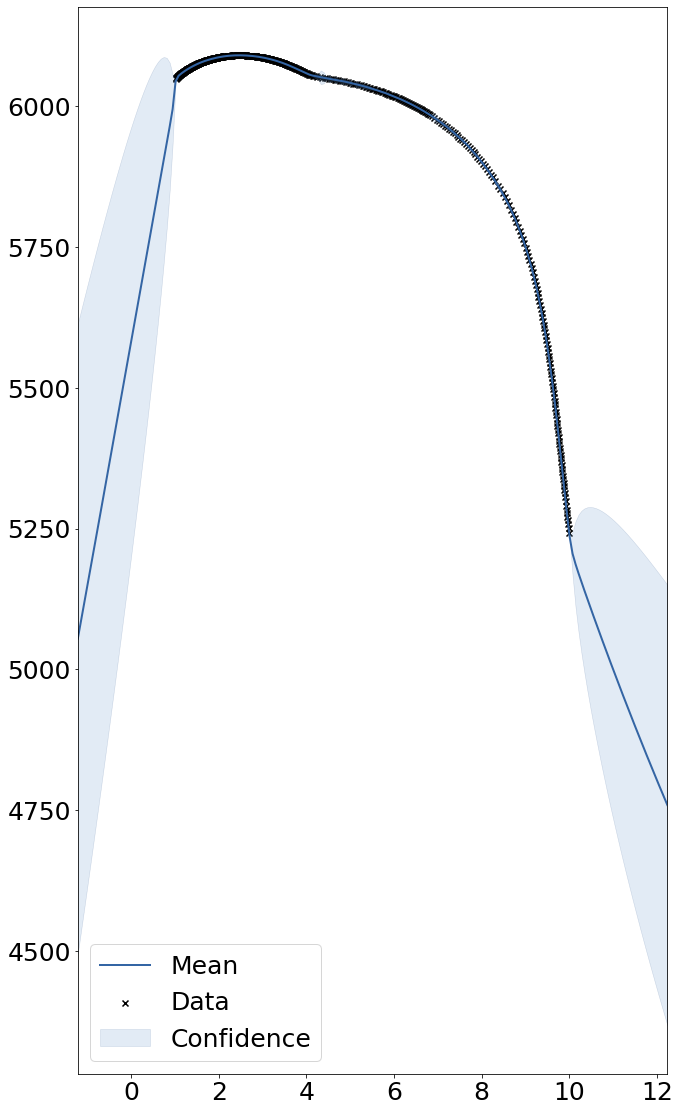

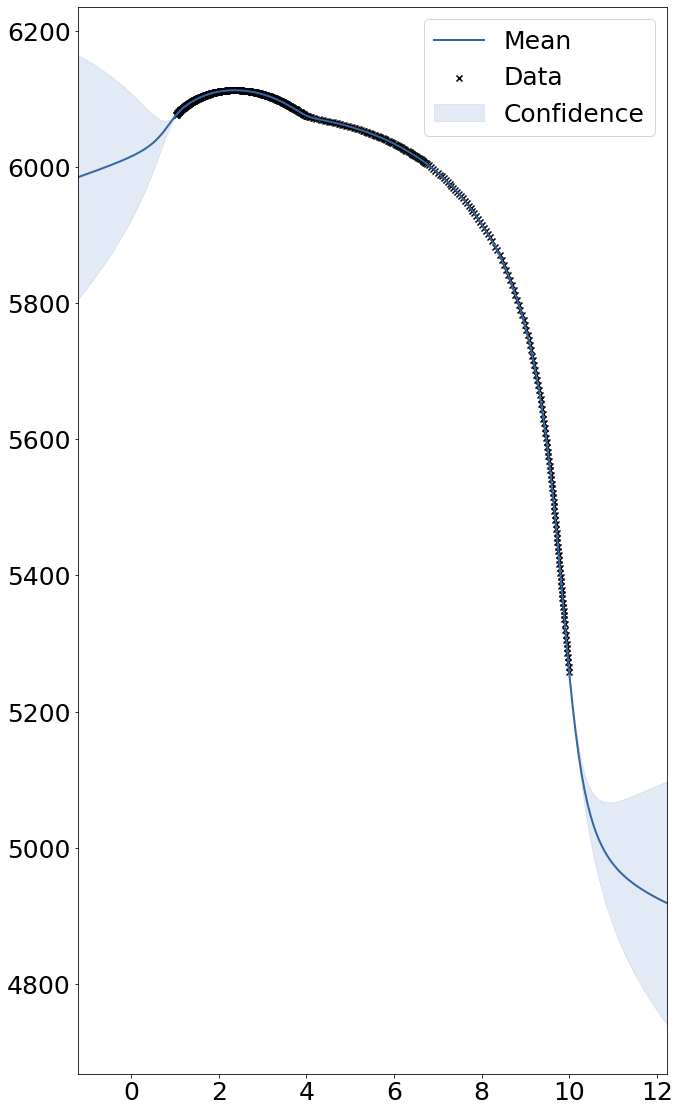

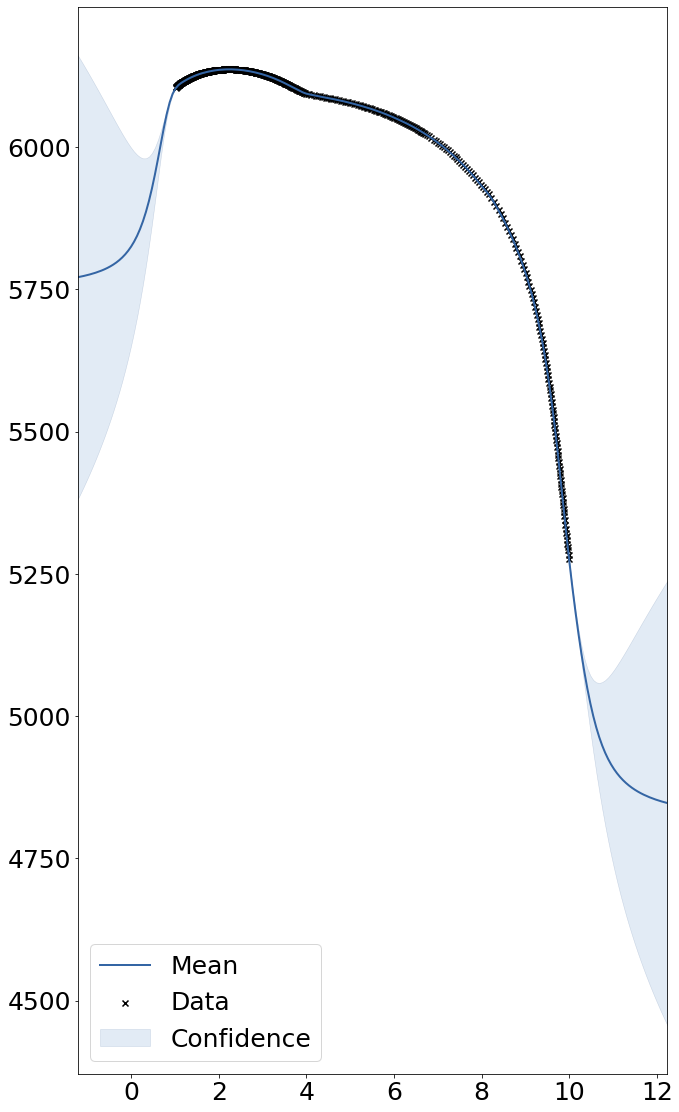

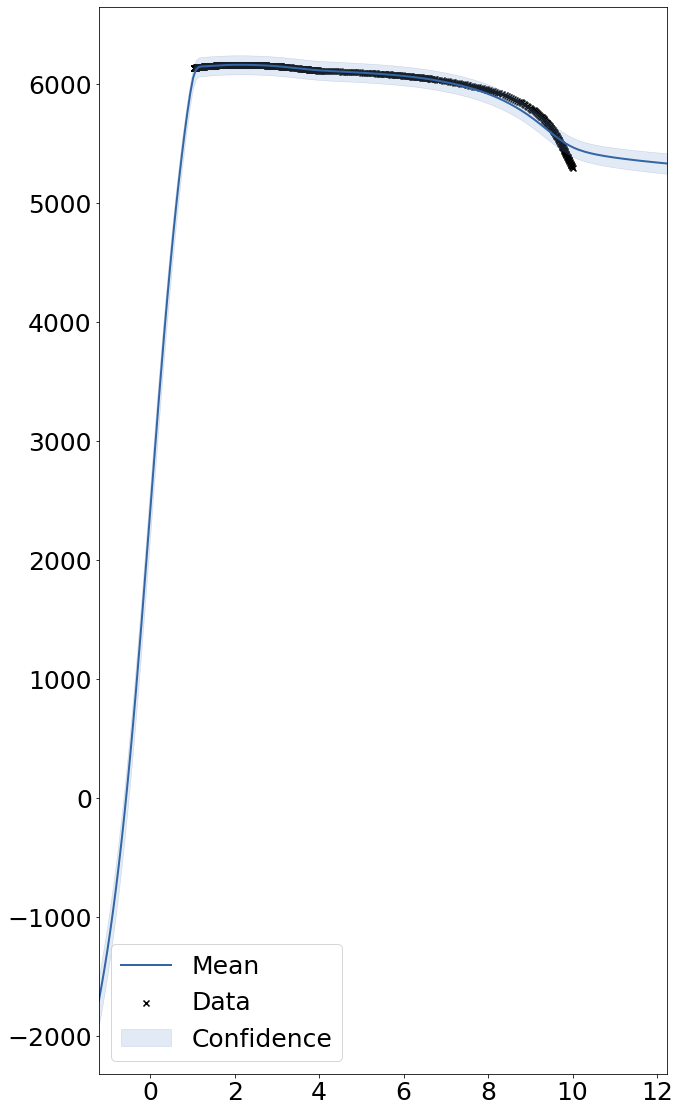

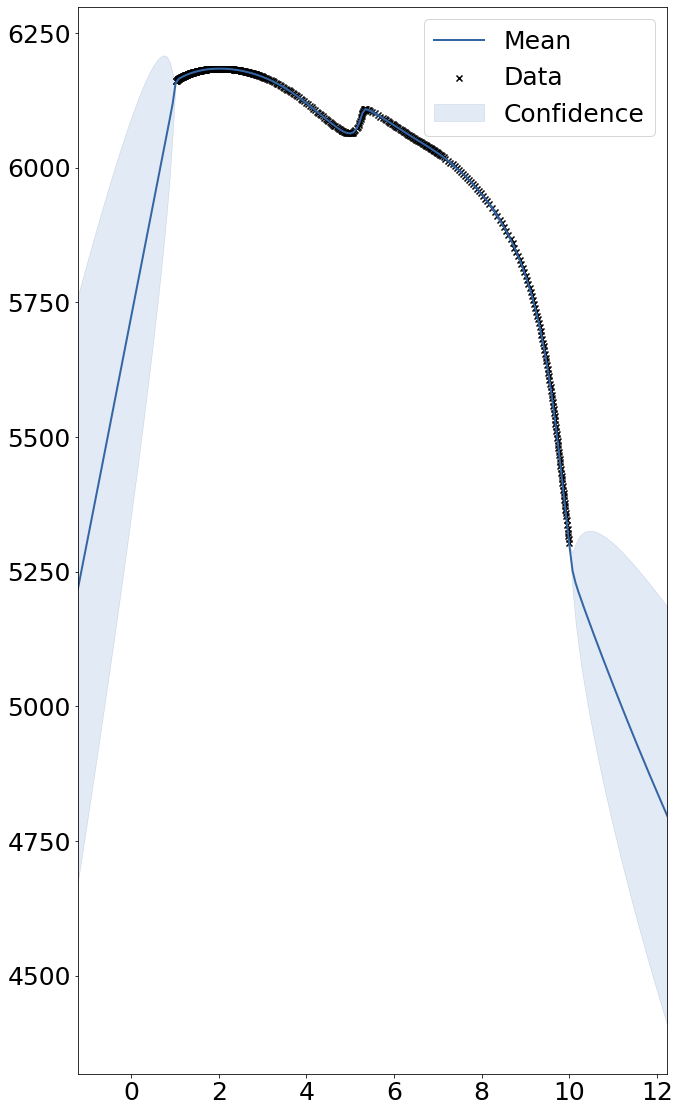

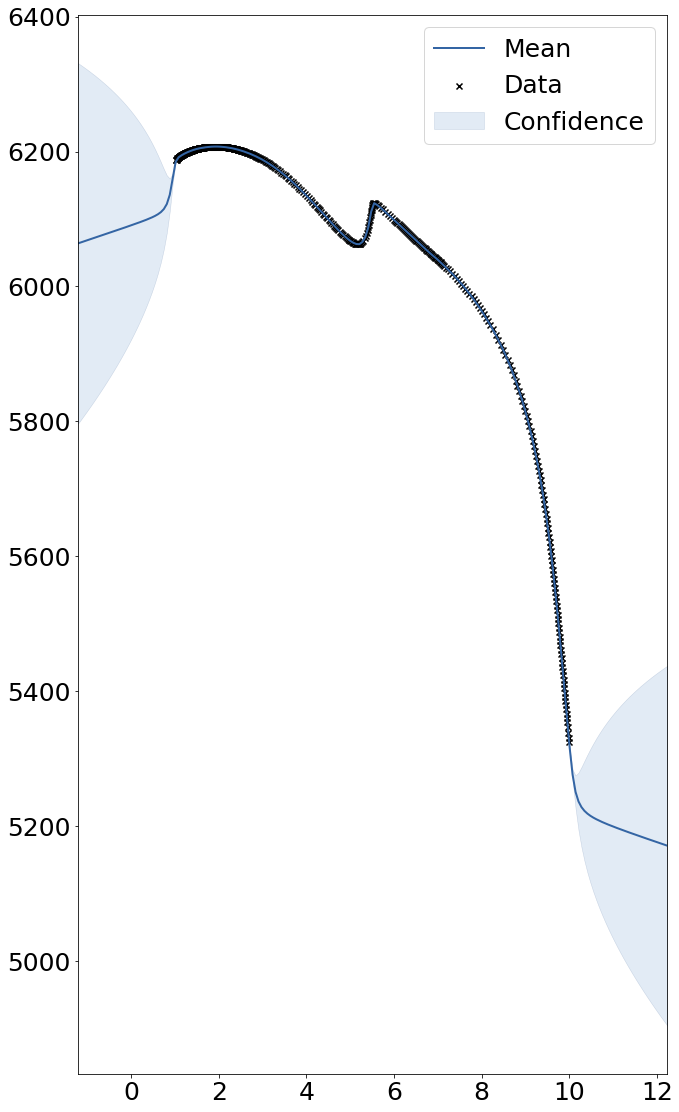

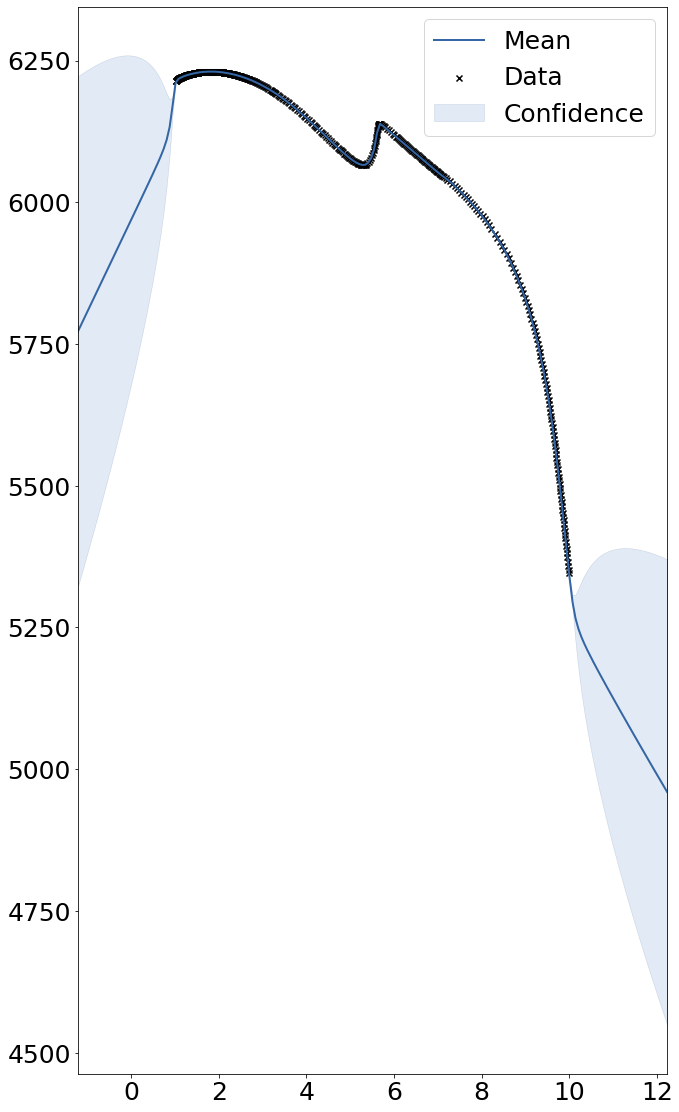

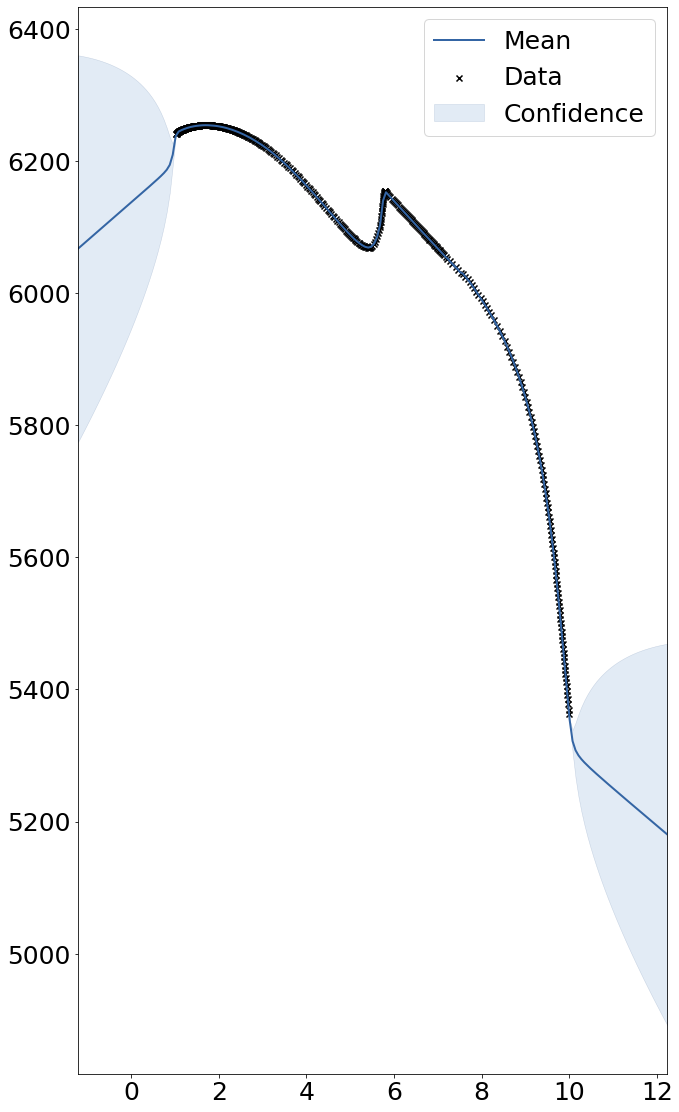

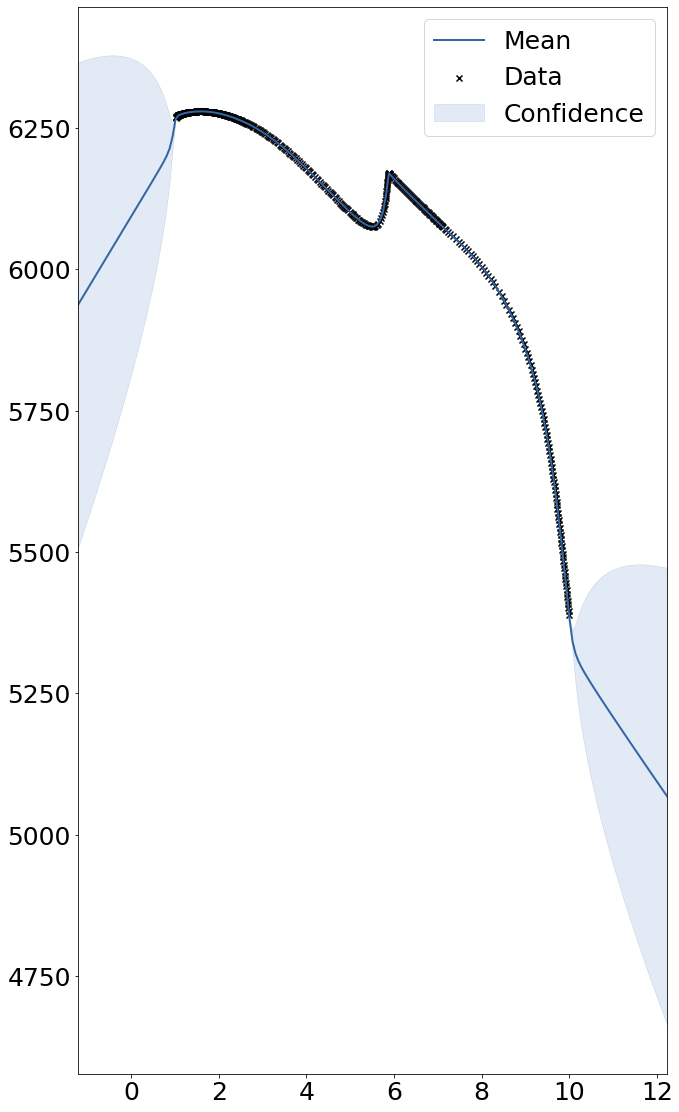

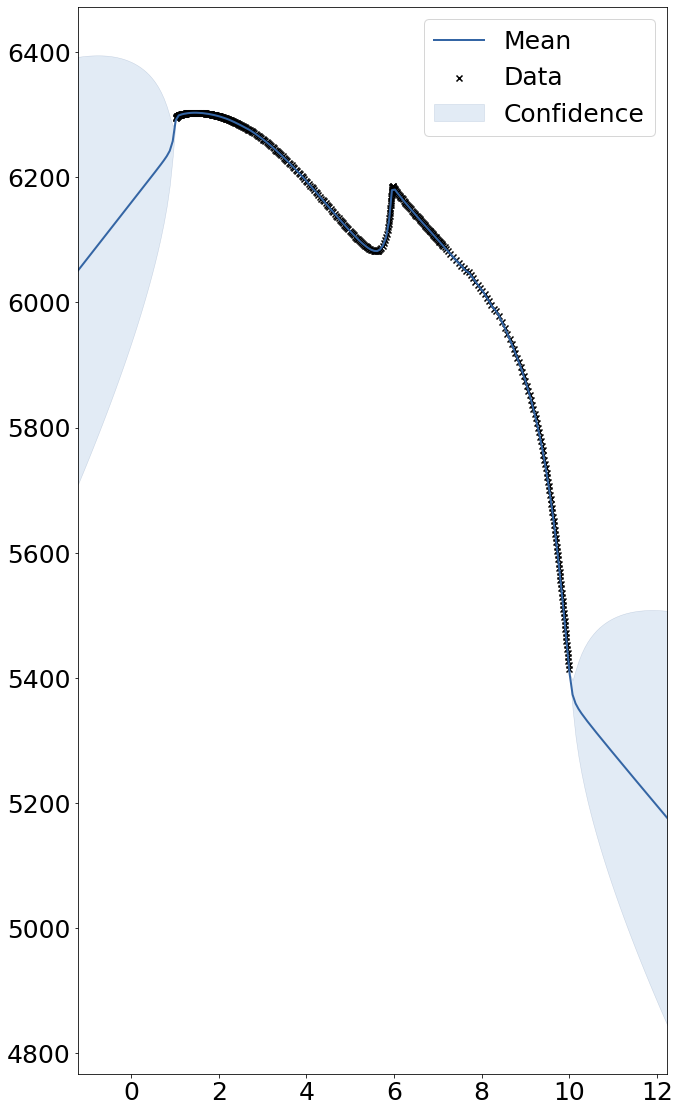

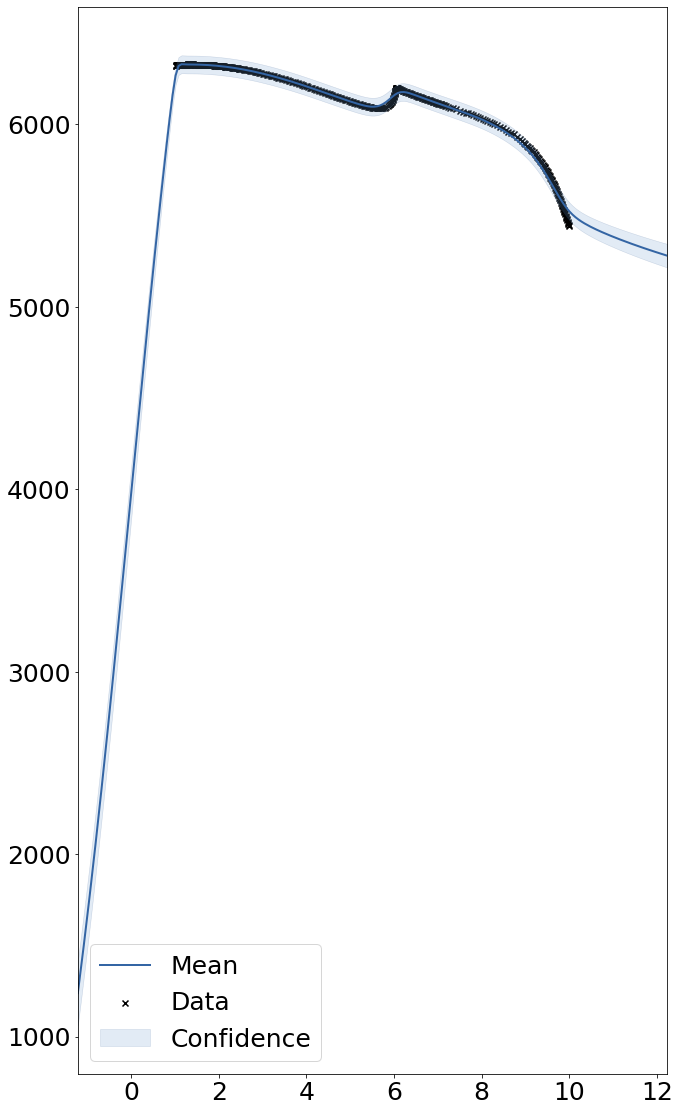

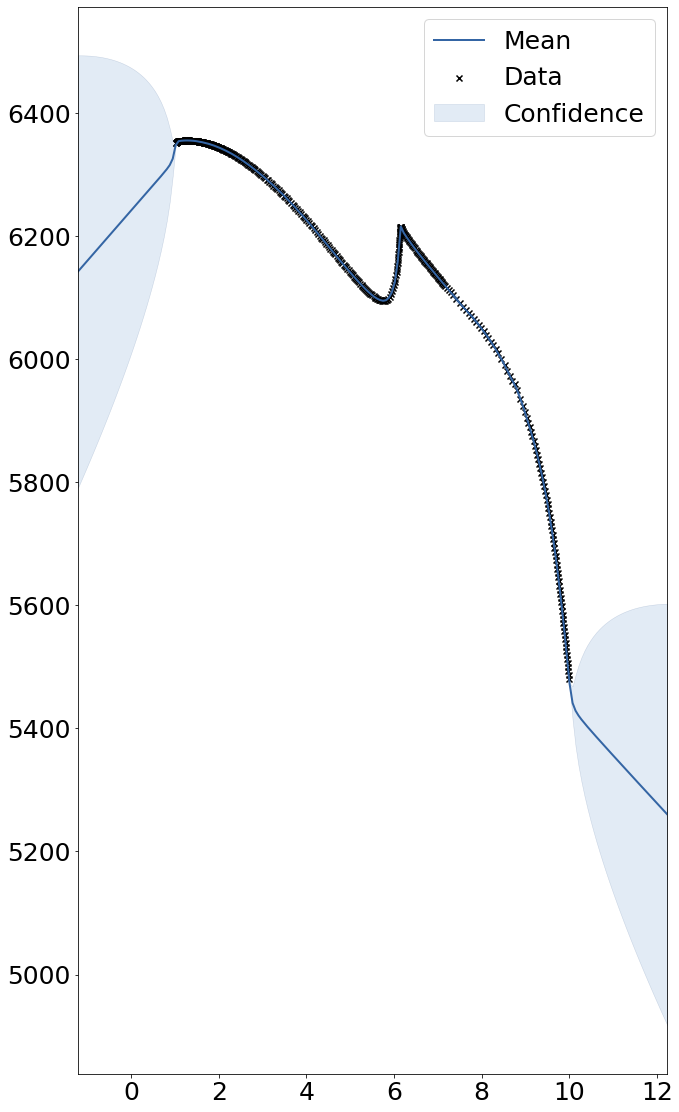

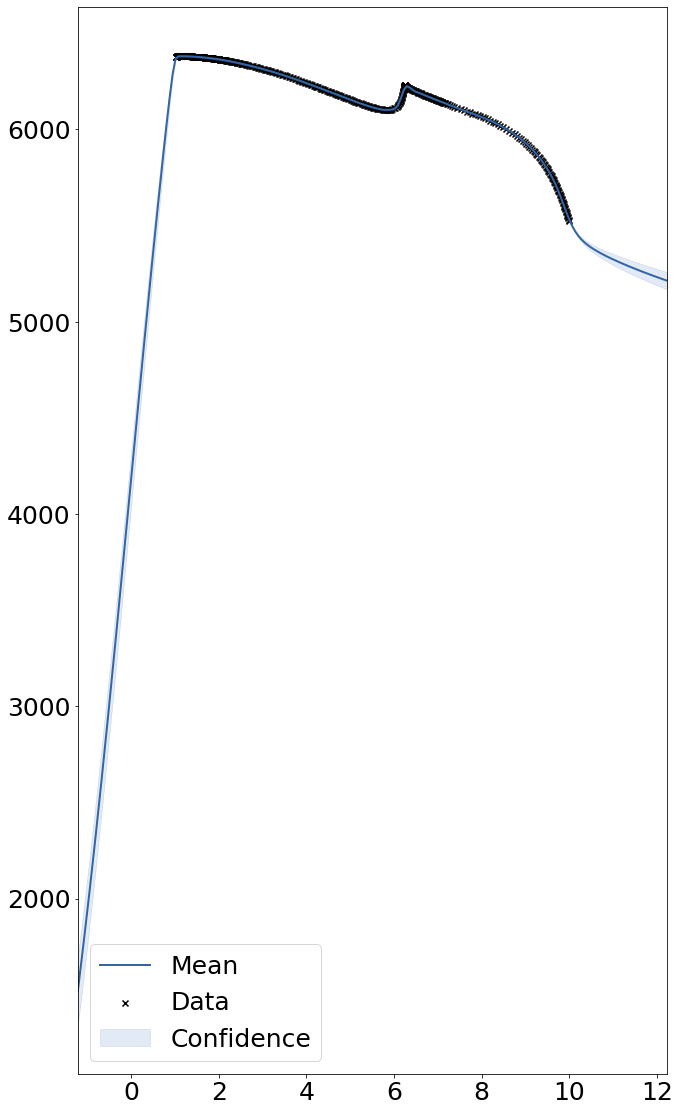

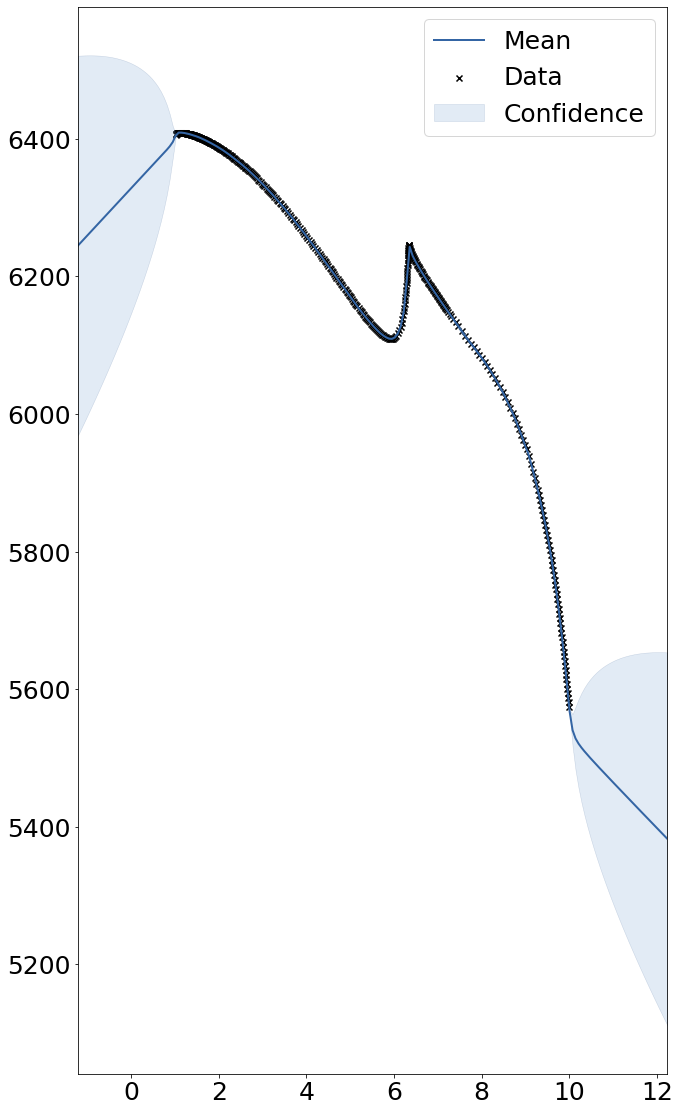

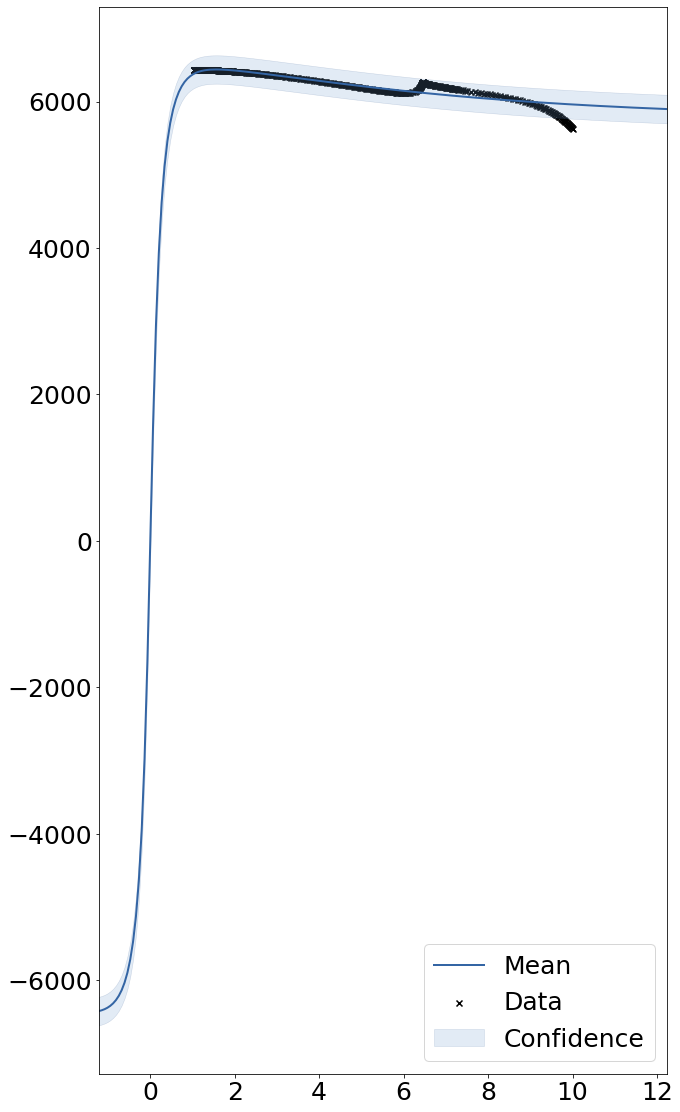

In [107]:
xgrid = np.linspace(0.8, 1.2, 41)
ygrid = np.linspace(1.5, 10.0, 1000)

dfs = []

for mass in xgrid:
    mass = round(mass, 2)
    print(mass)
    
    mc = np.full(len(ygrid), mass)
    tt = np.full(len(ygrid), 0.0)
    
    xdf = []
    xdf = pd.DataFrame({'initial_mass': mc, 'frac_age': ygrid, 'effective_T': tt} )
    
    dd = df[(df.initial_mass == mass)]
    dd.index = range(len(dd))
    
    #if (mass == 1.05):
    gg = gmk.gp_a_dataframe(df = dd, xcolumns = ['frac_age'], ycolumns = ['effective_T'], kname = 'MLP')
    #else: 
    #gg = gmk.gp_a_dataframe(df = dd, xcolumns = ['frac_age'], ycolumns = ['effective_T'], kname = 'MLP')
    gg.plot()
    pp = gmk.sample_with_df(n = 1, df = xdf, gpm = gg, 
                          xcolumns = ['frac_age'], xshift = [0.00], 
                          randomshift = False, ycolumns =['effective_T'])
    dfs.append(pp)

In [109]:
big_dfs = pd.concat(dfs, ignore_index=True)
big_dfs.to_csv(gmk._savepath + 'massagegrid.csv')
big_dfs

initial_mass   frac_age  effective_T       gp_var
0               0.8   1.500000  5163.637369     0.000693
1               0.8   1.508509  5164.862350     0.000693
2               0.8   1.517017  5166.081245     0.000694
3               0.8   1.525526  5167.294267     0.000694
4               0.8   1.534034  5168.501549     0.000694
...             ...        ...          ...          ...
40995           1.2   9.965966  5961.025070  9784.005778
40996           1.2   9.974474  5960.739432  9784.276591
40997           1.2   9.982983  5960.454189  9784.547850
40998           1.2   9.991491  5960.169341  9784.819554
40999           1.2  10.000000  5959.884886  9785.091703

[41000 rows x 4 columns]

In [142]:
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T','log_g','radius', 'star_age','star_zx', 'delta_nu_fit']
gpp = df.copy()
gpp = gmk.sample_with_df(n = 1, df = df, gpm = gpm0, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)
gpp['star_feh'] = np.log10(gpp['star_zx']/0.0181)

dd = df.copy()

dd[ycolumns] = (df[ycolumns] - gpp[ycolumns])

dd['weights'] = (np.abs(dd['effective_T']))
dd

evol_stage  initial_mass  initial_Yinit  initial_feh  initial_MLT  \
0               1          0.80           0.28          0.0          2.1   
1               1          0.80           0.28          0.0          2.1   
2               1          0.80           0.28          0.0          2.1   
3               1          0.80           0.28          0.0          2.1   
4               1          0.80           0.28          0.0          2.1   
...           ...           ...            ...          ...          ...   
21383           2          0.86           0.28          0.0          2.1   
21384           2          0.86           0.28          0.0          2.1   
21385           2          0.86           0.28          0.0          2.1   
21386           2          0.86           0.28          0.0          2.1   
21387           2          0.86           0.28          0.0          2.1   

       star_age   frac_age     ms_age  effective_T     log_g    radius  \
0     -0.015538   1.027059  17.621888     0.674017  0.001074 -0.000742   
1     -0.011608   1.031425  17.621888     0.305042  0.000689 -0.000461   
2     -0.007556   1.036689  17.621888     0.069369  0.000370 -0.000235   
3     -0.003591   1.043040  17.621888    -0.049015  0.000122 -0.000066   
4     -0.000015   1.050714  17.621888    -0.071826 -0.000050  0.000043   
...         ...        ...        ...          ...       ...       ...   
21383  0.000134   9.978179  13.258939    -0.045082  0.000034 -0.000124   
21384  0.000054   9.983753  13.258939    -0.010616  0.000021 -0.000070   
21385 -0.000055   9.989254  13.258939     0.030124 -0.000004  0.000021   
21386 -0.000194   9.994675  13.258939     0.026875 -0.000084  0.000244   
21387 -0.000366  10.000000  13.258939     0.093762 -0.000122  0.000384   

       star_feh  delta_nu_fit       nu_max  hrgradient  fagegradient  \
0     -0.001870      0.365934  5146.064335    0.000192      0.002031   
1     -0.002207      0.233808  5135.777983    0.000207      0.002438   
2     -0.002611      0.124567  5124.983518    0.000236      0.002925   
3     -0.003095      0.040406  5113.511271    0.000278      0.003510   
4     -0.003675     -0.017608  5101.144110    0.000277      0.003521   
...         ...           ...          ...         ...           ...   
21383 -0.027591      0.000375   790.573406    0.000784      0.000303   
21384 -0.027314      0.000570   785.477965    0.000772      0.000298   
21385 -0.027038     -0.000044   780.444503    0.000768      0.000294   
21386 -0.026899     -0.004357   775.407719    0.000753      0.000289   
21387 -0.026622     -0.005478   770.552175    0.000739      0.000284   

       initial_zx       star_zx   weights  
0          0.0181  4.744836e-06  0.674017  
1          0.0181  3.540725e-06  0.305042  
2          0.0181  2.288235e-06  0.069369  
3          0.0181  1.054417e-06  0.049015  
4          0.0181 -6.915735e-08  0.071826  
...           ...           ...       ...  
21383      0.0181 -1.742095e-06  0.045082  
21384      0.0181  1.180271e-08  0.010616  
21385      0.0181  1.959631e-06  0.030124  
21386      0.0181 -1.340963e-06  0.026875  
21387      0.0181  1.022141e-06  0.093762  

[21388 rows x 19 columns]

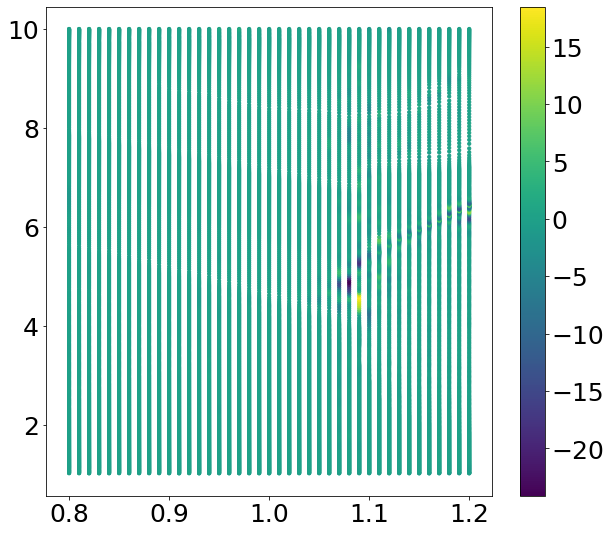

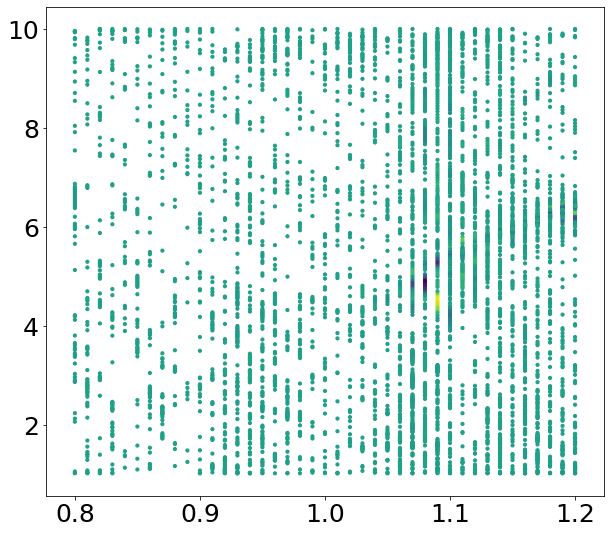

In [143]:
fig, ax = plt.subplots()
cp = plt.scatter(dd['initial_mass'], dd['frac_age'], c = dd['effective_T'],s = 10)
cc = plt.colorbar(cp)

fig, ax = plt.subplots()
gdfr = dd.sample(n = 5000, weights = 'weights', random_state = 500)
gdfr.index = range(len(gdfr))
cp = plt.scatter(gdfr['initial_mass'], gdfr['frac_age'], c = gdfr['effective_T'],s = 10)

 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


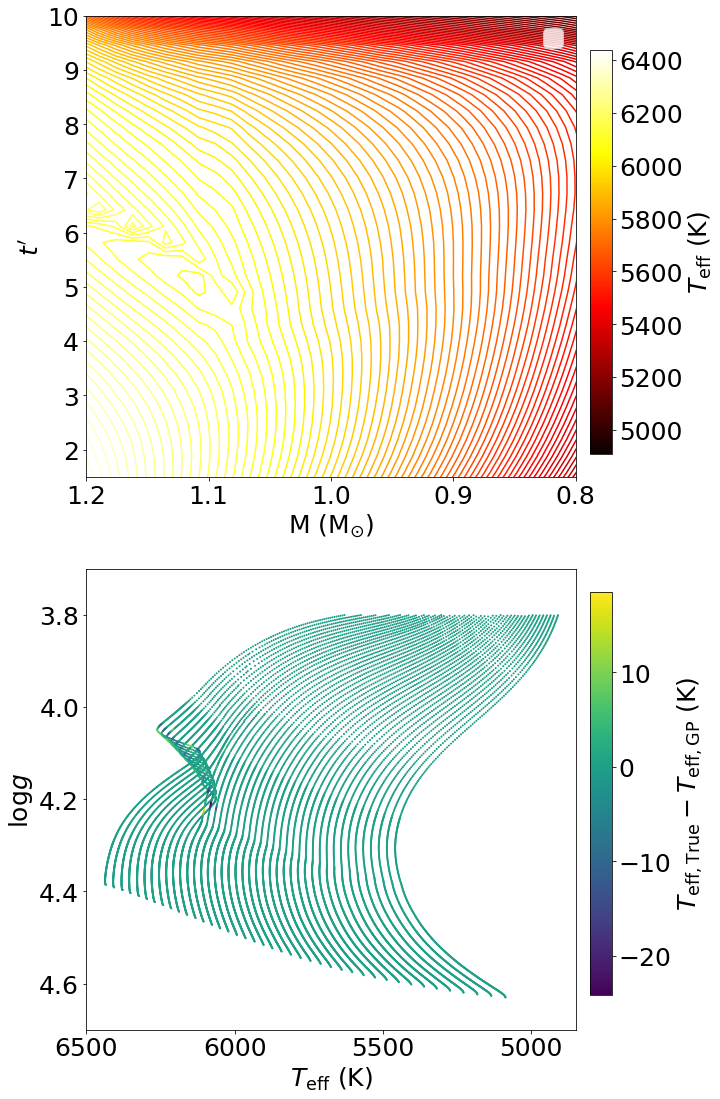

In [233]:
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (10, 9),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, (ax, ax1) = plt.subplots(2,1, figsize = (10,16))

import scipy

#x = big_dfs['initial_mass']
#y = big_dfs['frac_age']
#z = big_dfs['effective_T']

#xgrid = np.linspace(0.8, 1.2, 41)
#ygrid = np.linspace(1.5, 10.0, 1000)

#xgrid, ygrid = np.meshgrid(xgrid, ygrid)
#zgrid = scipy.interpolate.griddata((x,y),z, (xgrid, ygrid), method='nearest')

#ax.contour(xgrid, ygrid, zgrid, 100, colors = 'grey')   

gpm0.plot(ax = ax, which_data_rows='all', which_data_ycols=[0],plot_data = False, levels = 100,label= None)
ax.set_xlabel(r'M (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
ax.set_xlim([1.2,0.8])
ax.set_ylim([1.5,10])
ax.set_position([0.12,0.55,0.68,0.4])
cbaxes = fig.add_axes([0.82, 0.57, 0.03, 0.35]) 

cp = ax.scatter([0,0],[0,0], c = [np.min(gdf['effective_T']), np.max(gdf['effective_T'])], cmap = 'hot')

#colorbar = ax.colorbar(cp, orientation=None, pad=0.2) 
colorbar = plt.colorbar(cp, cax = cbaxes)
colorbar.set_label(r'$T_{\rm eff}$ (K)')

cp = ax1.scatter(df['effective_T'], df['log_g'], c = dd['effective_T'], cmap = None, s = 1)
ax1.set_position([0.12,0.07,0.68,0.4])
cbaxes = fig.add_axes([0.82, 0.10, 0.03, 0.35]) 
colorbar = plt.colorbar(cp, cax = cbaxes)
colorbar.set_label(r'$T_{\rm eff, True} - T_{\rm eff, GP}$ (K)')
ax1.set_xlabel(r'$T_{\rm eff}$ (K)')
ax1.set_ylabel(r"$\log g$")
ax1.set_xlim([6500,4850])
ax1.set_ylim([4.7,3.7])
fig.savefig(gmk._savepath + '2d_gpmodel_MLP.pdf')

In [91]:
# work on residual
textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

gpm_mlp = gmk.gp_a_dataframe(df = gdfr, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP')
gpm_rbf = gmk.gp_a_dataframe(df = gdfr, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'RBF')
gpm_exp = gmk.gp_a_dataframe(df = gdfr, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'EXP')
gpm_rq = gmk.gp_a_dataframe(df = gdfr, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'RQ')
gpm_mat32 = gmk.gp_a_dataframe(df = gdfr, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'Mat32')

--- 447.89957094192505 seconds ---
--- 859.6564750671387 seconds ---
--- 68.80879497528076 seconds ---


 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


--- 212.35782384872437 seconds ---
--- 227.6789848804474 seconds ---


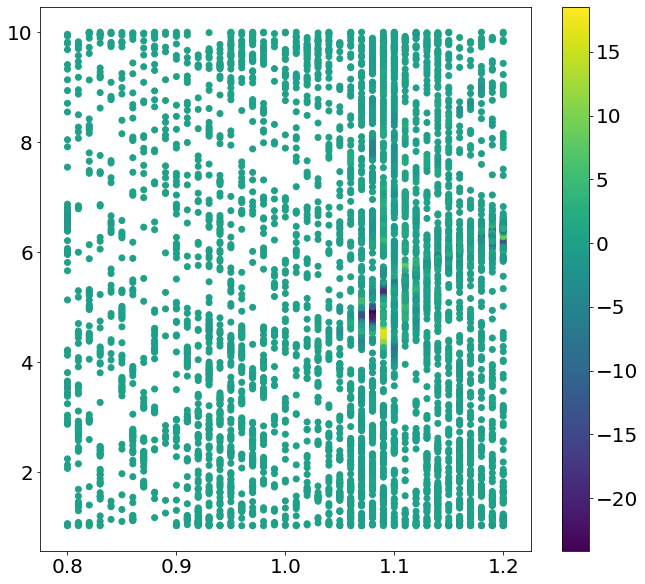

In [69]:
gdfr.index = range(len(gdfr))
cp = plt.scatter(gdfr['initial_mass'], gdfr['frac_age'], c = gdfr['effective_T'])
plt.colorbar(cp)

In [70]:
#with open(gmk._savepath + "3d_all.dump" , "wb") as f:
#     pickle.dump(gpm, f) 
#with open(gmk._savepath + "3d_all.dump" , 'rb') as f:
#    gpm = pickle.load(f)

#gdf = pd.read_csv(gmk._savepath + '')

#gpm = gmk.load_a_model(npyfile = npyfile, df = gdf, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP')

#gpm = GPy.models.GPRegression(X, Y, initialize=False)
#gpm.update_model(False) # do not call the underlying expensive algebra on load
#gpm.initialize_parameter() # Initialize the parameters (connect the parameters up)
#gpm[:] = np.load('model_save.npy') # Load the parameters
#gpm.update_model(True) # Call the algebra only once

In [211]:
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T','log_g','radius', 'star_age','star_zx', 'delta_nu_fit']

dfs = df

gp = gmk.sample_with_df(n = 1, df = dfs, gpm = gpm0, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)

gpr_mlp = gmk.sample_with_df(n = 1, df = dfs, gpm = gpm_mlp, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)
gpr_mlp[ycolumns] = gp[ycolumns] + gpr_mlp[ycolumns]

gpr_exp = gmk.sample_with_df(n = 1, df = dfs, gpm = gpm_exp, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)
gpr_exp[ycolumns] = gp[ycolumns] + gpr_exp[ycolumns]


gpr_rbf = gmk.sample_with_df(n = 1, df = dfs, gpm = gpm_rbf, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)
gpr_rbf[ycolumns] = gp[ycolumns] + gpr_rbf[ycolumns]



gpr_rq = gmk.sample_with_df(n = 1,   df = dfs, gpm = gpm_rq, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)
gpr_rq[ycolumns] = gp[ycolumns] + gpr_rq[ycolumns]



gpr_mat32 = gmk.sample_with_df(n = 1,   df = dfs, gpm = gpm_mat32, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)
gpr_mat32[ycolumns] = gp[ycolumns] + gpr_mat32[ycolumns]


11.037585889075672
7.349971938356248
18.214876890937376
6.443204455493287
1.0089588361306596


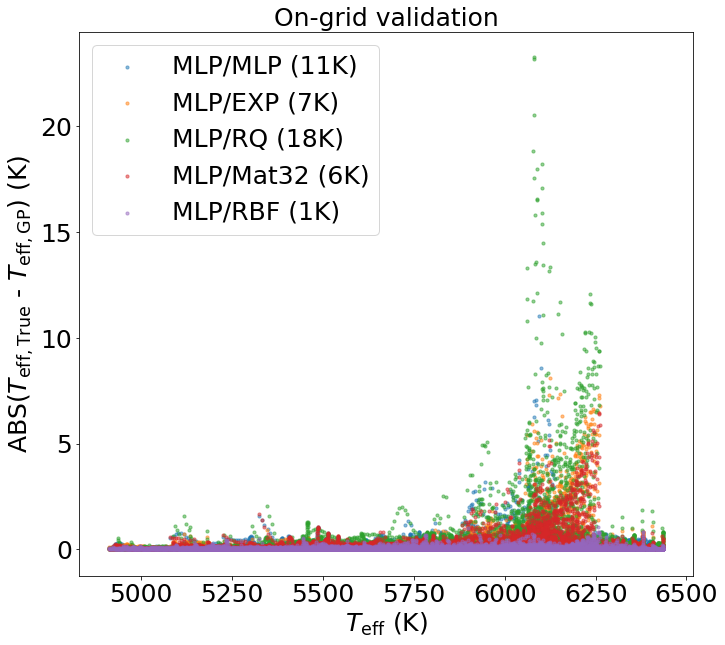

In [214]:
# work on residual
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, (ax) = plt.subplots(1,1)
#cp = ax.scatter(gdfr['initial_mass'], gdfr['frac_age'], c = gdfr['effective_T'])
#plt.colorbar(cp)

gprs = [gpr_mlp, gpr_exp, gpr_rq, gpr_mat32,gpr_rbf]
labels = [r'MLP/MLP (11K)', 'MLP/EXP (7K)',  'MLP/RQ (18K)', 'MLP/Mat32 (6K)','MLP/RBF (1K)']

for i in range(0,5): #[4,3,2,1,0]:
    predictions =  gprs[i]['effective_T']

    ax.scatter(dfs['effective_T'], np.abs(dfs['effective_T'] - predictions), label = labels[i],s = 10, alpha = 0.5)
    print(np.max(dfs['effective_T'] - predictions))

ax.set_xlabel(r'$T_{\rm eff}$ (K)')
ax.set_ylabel(r'ABS($T_{\rm eff, True}$ - $T_{\rm eff, GP}$) (K)')
ax.set_title('On-grid validation')
ax.legend()
fig.savefig(gmk._savepath + '2d_residual.pdf')

# validating GP predictions with validation data

In [171]:
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T','log_g','radius', 'star_age','star_zx', 'delta_nu_fit']

dfs = dfv

gp = gmk.sample_with_df(n = 1, df = dfs, gpm = gpm0, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)


gpr_rbf = gmk.sample_with_df(n = 1, df = dfs, gpm = gpm_rbf, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)
gpdfv0 = gp[ycolumns] + gpr_rbf[ycolumns]
gpdfv0['star_feh'] = np.log10(gpdfv0['star_zx']/0.0181)


In [174]:
ycolumns = ['star_age','delta_nu_fit', 'effective_T','log_g','radius', 'star_feh' ]
data0 = (gpdfv0[ycolumns] - dfv[ycolumns])

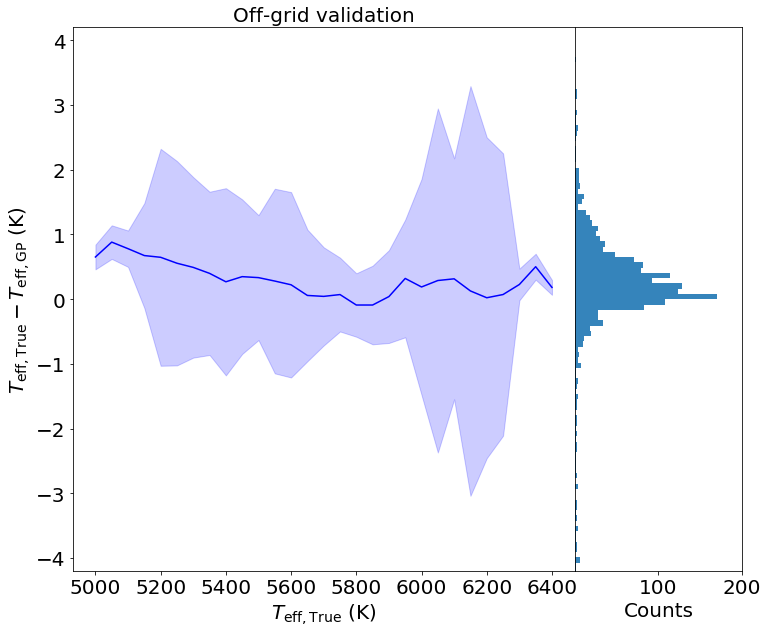

In [210]:
fig, ax = plt.subplots(1,2, figsize = (12,10), gridspec_kw={'width_ratios': [3, 1]})
x1 =  np.round(dfv[ycolumns[2]]/50, 0)*50
y1 = data0[ycolumns[2]]
xtd1, ym1, ytd1 = std(x1, y1)
ax[0].plot(xtd1, ym1, c = 'b')
ax[0].fill_between(xtd1, (ym1-ytd1), (ym1+ytd1), color='b', alpha=.2)
ax[0].set_xlabel(r'$T_{\rm eff, True}$ (K)')
ax[0].set_ylabel(r'$T_{\rm eff, True} - T_{\rm eff, GP}$ (K)')
ax[0].set_title('Off-grid Validation')
ax[0].set_ylim([-4.2,4.2])

ax[1].hist(y1,bins = 400,orientation = 'horizontal',alpha = 0.9)
ax[1].set_yticks([])
ax[1].set_xlabel('Counts')
ax[1].set_ylim([-4.2,4.2])
ax[1].set_xlim([1,200])

plt.subplots_adjust(wspace=0)
fig.savefig(gmk._savepath + '2d_validation_teff.pdf')

In [229]:
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T','log_g','radius', 'star_age','star_zx', 'delta_nu_fit']
sdf = df.copy()
sdf = pd.concat((sdf, sdf))
sdf.index = range(len(sdf))
sdf['initial_mass'] = np.random.random(len(sdf))*0.4 + 0.8
sdf['frac_age'] = np.random.random(len(sdf))*8.9 + 1.0

sgp = gmk.sample_with_df(n = 1, df = sdf, gpm = gpm0, 
                          xcolumns = xcolumns, xshift = [0.00,0.00], 
                          randomshift = False, ycolumns = ycolumns)


sgpr_rbf = gmk.sample_with_df(n = 1, df = sdf, gpm = gpm_rbf, 
                              xcolumns = xcolumns, xshift = [0.00,0.00], 
                              randomshift = False, ycolumns = ycolumns)
sgp = sgp[ycolumns] + sgpr_rbf[ycolumns]
sgp['star_feh'] = np.log10(sgp['star_zx']/0.0181)

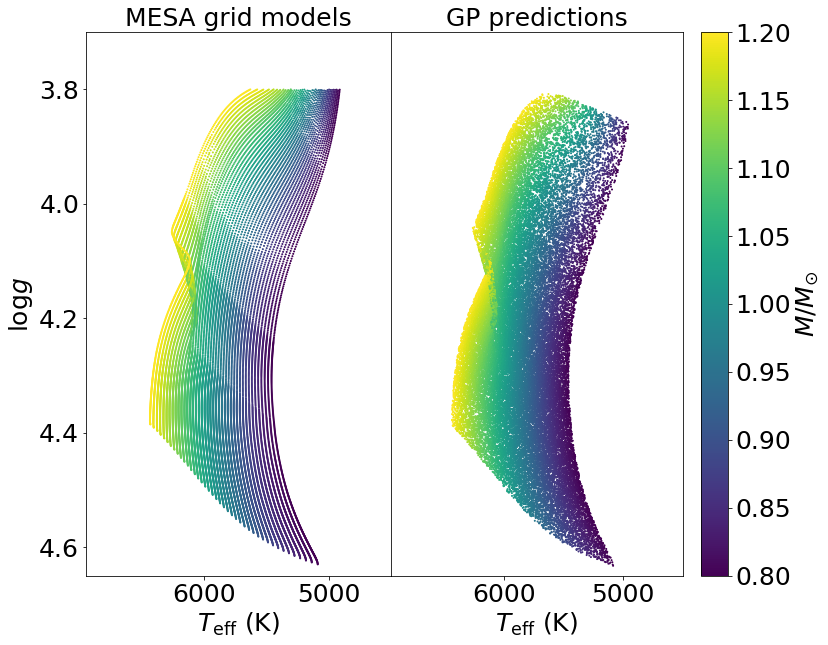

In [230]:
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1.2]})
cp = ax1.scatter(df['effective_T'], df['log_g'], c = df['initial_mass'],s = 1) #,cmap = 'winter')
ax1.set_xlabel(r'$T_{\rm eff}$ (K)')
ax1.set_ylabel(r'$\log g$')
ax1.set_xlim([6950,4501])
ax1.set_ylim([4.65,3.7])
ax1.set_title('MESA grid models')

ax2.scatter(sgp['effective_T'], sgp['log_g'], c = sdf['initial_mass'],s = 1)#,cmap = 'winter')
ax2.set_xlabel(r'$T_{\rm eff}$ (K)')
ax2.set_xlim([6950,4501])
ax2.set_ylim([4.65,3.7])
ax2.set_title('GP predictions')
ax2.set_yticks([])


colorbar = plt.colorbar(cp)
colorbar.set_label(r'$M/M_{\odot}$')
#fig.tight_layout()
plt.subplots_adjust(wspace=0)
fig.savefig(gmk._savepath + '2d_hrd_compare.pdf')

0.6145504605095198 1.8436513815285593 1.080219821592858
0.01990779973180679 0.05972339919542037 0.0633443233337258
0.3698588911611296 1.9417591785959303 1.5275952930322054
0.1446005563309427 0.5784022253237708 0.5135633370031192
0.2195798384763692 1.171092471873969 0.9961638112147811
0.10726872754336925 0.7508810928035847 1.8288280732055573


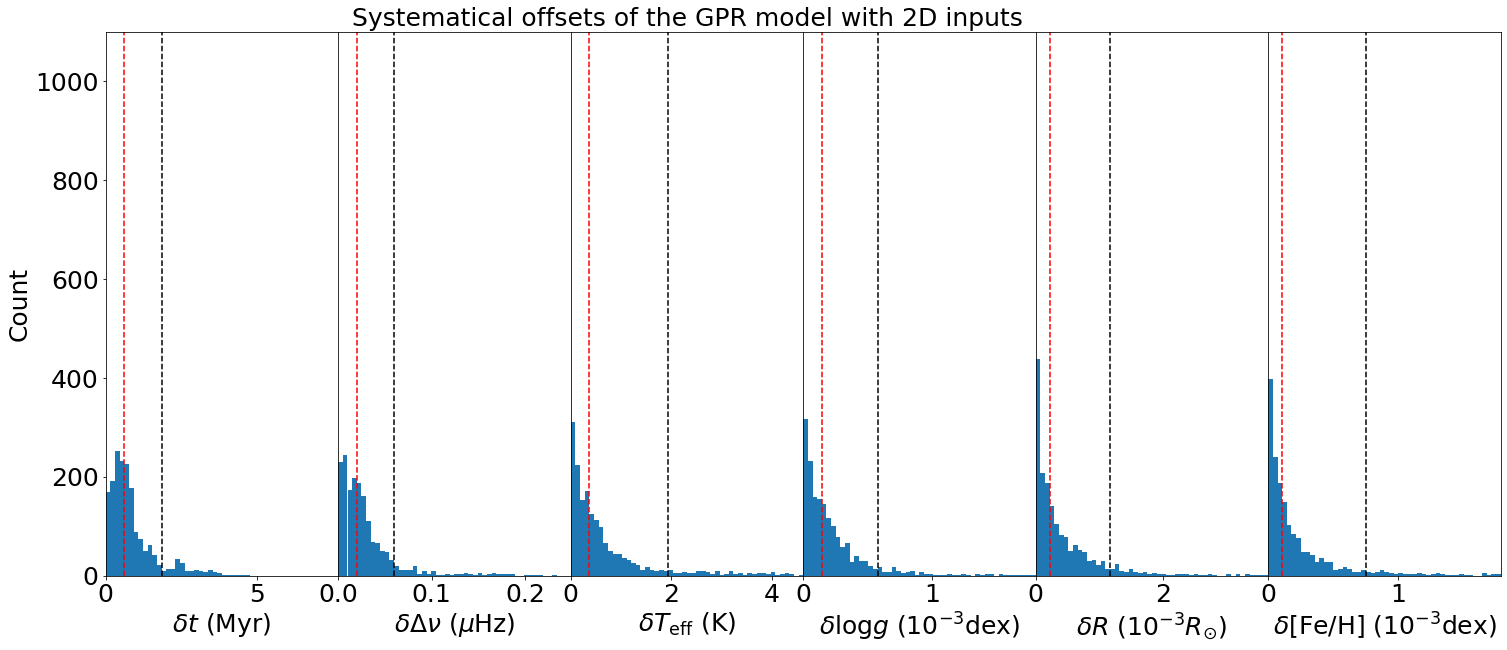

In [172]:


data0[['star_age','log_g','radius', 'star_feh']] = data0[['star_age','log_g','radius', 'star_feh' ]]*1000.0
data = np.abs(data0)

textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(1,6, figsize = (25,10))
labels=[r'$\delta t$ (Myr)', r'$\delta \Delta\nu$ ($\mu$Hz)',r'$\delta T_{\rm eff}$ (K)', 
        r'$\delta \log g$ ($10^{-3}$dex)' , r'$\delta R$ ($10^{-3}R_{\odot}$)', r'$\delta$[Fe/H] ($10^{-3}$dex)']
ranges = [(-0.0,0.38),(-0.0,0.38),(-0.0,0.38),(-0.00,0.8), (-.0,.38),(-.0,1.4),(-0.0,1.4)]

for i in range(0,6):
    xup = np.median(data[ycolumns[i]])*12.0
    if i>=4: xup = np.median(data[ycolumns[i]])*15.0


    n,bins, patch = ax[i].hist((data[ycolumns[i]]),bins=50,range = [0,xup])

    t = 0.0
    centre = -999
    for j in range(len(n)):
        t = t + n[j]
        if t > 0.5*len(data):
            ax[i].plot([bins[j],bins[j]], [0,10000], 'r--')
            centre = bins[j]
            break
    
    t = 0.0
    sigma2 = -999
    for j in range(len(n)):
        t = t + n[j]
        if t > 0.90*len(data):
            ax[i].plot([bins[j],bins[j]], [0,10000], 'k--')
            sigma2 = bins[j]
            break
    
    std = np.std(data0[ycolumns[i]])
    #ax[i].plot([std,std], [0,10000], 'b--')
            
    print(centre, sigma2, std)
    
    if i != 0: ax[i].set_yticks([])
    if i == 0: ax[i].set_ylabel('Count')
    ax[i].set_xlim([0,xup])
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylim(0,1100)
    if i == 2: ax[i].set_title('Systematical offsets of the GPR model with 2D inputs')

plt.subplots_adjust(wspace=0)
fig.savefig(gmk._savepath + '2d_validation_x.pdf')

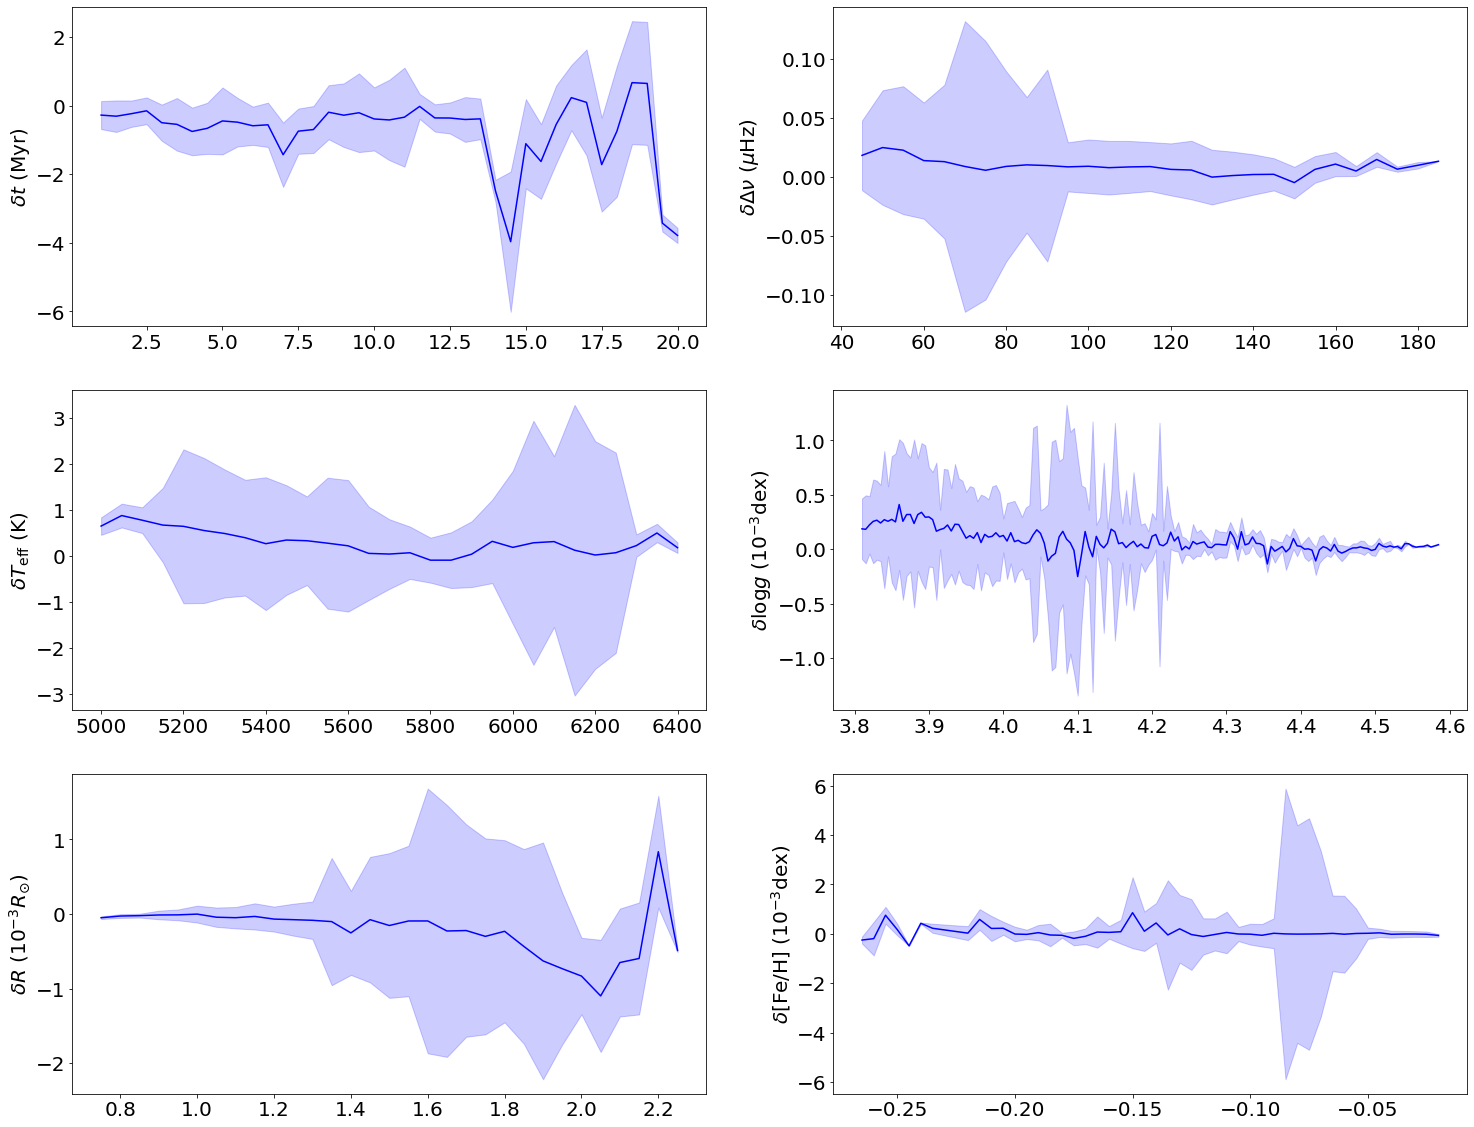

In [173]:
def std(x, y):
    xx = np.unique(x)
    xx = np.sort(xx)
    ymedian = xx*0.0
    ystd = xx*0.0
    for i in range(len(xx)):
        idex = (x == xx[i])
        ymedian[i] = np.median(y[idex])
        ystd[i] = np.std(y[idex])
    return xx, ymedian, ystd

ycolumns = ['star_age','delta_nu_fit', 'effective_T','log_g','radius', 'star_feh' ]
data0 = (gpdfv0[ycolumns] - dfv[ycolumns])

data0[['star_age','log_g','radius', 'star_feh']] = data0[['star_age','log_g','radius', 'star_feh' ]]*1000.0
data = np.abs(data0)

textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(3,2, figsize = (25,20))
labels=[r'$\delta t$ (Myr)', r'$\delta \Delta\nu$ ($\mu$Hz)',r'$\delta T_{\rm eff}$ (K)', 
        r'$\delta \log g$ ($10^{-3}$dex)' , r'$\delta R$ ($10^{-3}R_{\odot}$)', r'$\delta$[Fe/H] ($10^{-3}$dex)']
ranges = [(-0.0,0.38),(-0.0,0.38),(-0.0,0.38),(-0.00,0.8), (-.0,.38),(-.0,1.4),(-0.0,1.4)]

digits = [2,1,0,4,3,4]

i = 0

for k in range(0,3):
    for j in range(0,2):
      
        #if (k==2) & (j==0 or j==2): 
        #    ax[k, j].remove()
         #   continue
    
        x1 =  np.round(dfv[ycolumns[i]]/50, digits[i])*50

        y1 = data0[ycolumns[i]]
        
        xtd1, ym1, ytd1 = std(x1, y1)
        
        ax[k, j].plot(xtd1, ym1, c = 'b')
        ax[k, j].fill_between(xtd1, (ym1-ytd1), (ym1+ytd1), color='b', alpha=.2)
    
    #ax[i].set_yticks([])
        ax[k,j].set_ylabel(labels[i])
        
        i = i+1
    #ax[i].set_xlim([0,xup])
    #ax[i].set_xlabel(labels[i])
    #ax[i].set_ylim(0,1100)

#plt.subplots_adjust(wspace=0)
fig.savefig(gmk._savepath + '2d_validation_final.pdf')

# we also want to see the differences distribute randomly or correlates to any inputs

# Use GPR model to predict stellar parameters

# Look, now we have a non-sparse model! 